<a href="https://colab.research.google.com/github/texaschikkita/7333QTW/blob/main/FINAL_JMcPhaul_7333_CaseStudy2_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/texaschikkita/7333QTW/blob/main/FINAL_JMcPhaul_7333_CaseStudy2_diabetes.ipynb

In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import psutil
print(f"Available Memory: {psutil.virtual_memory().available / 1e9:.2f} GB")


Available Memory: 87.10 GB


In [3]:
import torch
import cupy as cp

# Check PyTorch CUDA availability
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version (PyTorch): {torch.version.cuda}")

# Check CuPy CUDA availability
print(f"CuPy CUDA available: {cp.cuda.is_available()}")
if cp.cuda.is_available():
    print(f"CUDA Version (CuPy): {cp.cuda.runtime.runtimeGetVersion() / 1000}")

    import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available.")

import cudf

print("cuDF is successfully installed!")

df = cudf.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
print(df)




PyTorch CUDA available: True
PyTorch Device: NVIDIA A100-SXM4-40GB
CUDA Version (PyTorch): 12.4
CuPy CUDA available: True
CUDA Version (CuPy): 12.06
CUDA is available!
Device: NVIDIA A100-SXM4-40GB
cuDF is successfully installed!
   a  b
0  1  4
1  2  5
2  3  6


In [4]:
# 2. EDA

import cudf


# Load the data into cuDF DataFrames
diabetic_data = cudf.read_csv("/content/drive/MyDrive/diabetic_data.csv")
ids_mapping = cudf.read_csv("/content/drive/MyDrive/IDs_mapping.csv")

# Ensure all string columns are treated as string type
diabetic_data = diabetic_data.astype(str)

# Replace '?' with None before converting to cuDF's NA
diabetic_data = diabetic_data.replace({'?': None}).fillna(cudf.NA)


# or (if needed) fix = convert only object clumns
# for col in diabetic_data.select_dtypes(include=['object']):
    # diabetic_data[col] = diabetic_data[col].replace({'?': None}).fillna(cudf.NA)


# Display dataset info
print("\n Diabetic Data Info:")
print(diabetic_data.info())

print("\n First few rows of diabetic_data:")
print(diabetic_data.head())

print("\n IDs Mapping Data Info:")
print(ids_mapping.info())

print("\n First few rows of IDs_mapping:")
print(ids_mapping.head())

# Check missing values
print("\n Missing values in dataset:")
missing_counts = diabetic_data.isnull().sum()
print(missing_counts[missing_counts > 0])


# 2.b
# # Convert columns back to proper types:
for col in diabetic_data.columns:
    if diabetic_data[col].str.isnumeric().all():
        diabetic_data[col] = diabetic_data[col].astype("int64")



 Diabetic Data Info:
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   encounter_id              101766 non-null  object
 1   patient_nbr               101766 non-null  object
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  object
 7   discharge_disposition_id  101766 non-null  object
 8   admission_source_id       101766 non-null  object
 9   time_in_hospital          101766 non-null  object
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  object
 13  num_procedures            101766 non-

In [5]:
#  Step 2.2 Fix Data Types and Handle Missing Values

import cudf

#  Convert Numeric Columns First
numeric_cols = [
    "encounter_id", "patient_nbr", "admission_type_id", "discharge_disposition_id",
    "admission_source_id", "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency", "number_inpatient",
    "number_diagnoses"
]

for col in numeric_cols:
    diabetic_data[col] = diabetic_data[col].astype("int64")

#  Convert Categorical Columns to String and Replace Missing Values
categorical_cols = [
    "race", "gender", "age", "payer_code", "medical_specialty",
    "diag_1", "diag_2", "diag_3", "max_glu_serum", "A1Cresult",
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "acetohexamide", "glipizide", "glyburide",
    "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose",
    "miglitol", "troglitazone", "tolazamide", "examide",
    "citoglipton", "insulin", "glyburide-metformin",
    "glipizide-metformin", "glimepiride-pioglitazone",
    "metformin-rosiglitazone", "metformin-pioglitazone",
    "change", "diabetesMed", "readmitted"
]

for col in categorical_cols:
    diabetic_data[col] = diabetic_data[col].astype("str").replace({'?': cudf.NA})

#  Verify Fix
print(" Data Types Fixed and Missing Values Handled!")
print(diabetic_data.dtypes)


 Data Types Fixed and Missing Values Handled!
encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorprop

In [6]:
# Merge ids

import cudf

#  Check for non-numeric values
invalid_values = ids_mapping[~ids_mapping["admission_type_id"].str.isnumeric()]
print(" Non-Numeric Values in `admission_type_id`:\n", invalid_values)

#  Convert numeric values to integers
ids_mapping = ids_mapping[ids_mapping["admission_type_id"].str.isnumeric()]
ids_mapping["admission_type_id"] = ids_mapping["admission_type_id"].astype("int64")

print("\n Cleaned `ids_mapping` Data:")
print(ids_mapping.head())


 Non-Numeric Values in `admission_type_id`:
            admission_type_id  description
9   discharge_disposition_id  description
41       admission_source_id  description

 Cleaned `ids_mapping` Data:
   admission_type_id    description
0                  1      Emergency
1                  2         Urgent
2                  3       Elective
3                  4        Newborn
4                  5  Not Available


In [7]:
# 3.2

#  Merge `diabetic_data` with `ids_mapping` on 'admission_type_id'
diabetic_data = diabetic_data.merge(ids_mapping, how="left", on="admission_type_id")

#  Drop unnecessary columns
columns_to_drop = [
    "weight", "max_glu_serum", "A1Cresult", "medical_specialty", "payer_code",
    "encounter_id", "patient_nbr", "description"  # 'description' is from ids_mapping
]
diabetic_data = diabetic_data.drop(columns=columns_to_drop)

#  Fill Missing Values in Key Categorical Columns
for col in ["race", "diag_1", "diag_2", "diag_3"]:
    diabetic_data[col] = diabetic_data[col].fillna("Unknown")

#  Convert 'readmitted' to numerical categories
diabetic_data["readmitted"] = diabetic_data["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

#  Verify Merge & Cleaning
print(" Merge Completed and Data Cleaned!")
print(diabetic_data.dtypes)
print("\n First Few Rows of Cleaned Data:")
print(diabetic_data.head())


 Merge Completed and Data Cleaned!
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone       

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the datasets
diabetic_data = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/diabetic_data.csv")
ids_mapping = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/IDs_mapping.csv")

# 3.2 Data Cleaning and Merging
# Convert 'admission_type_id' to numeric, handling non-numeric values
diabetic_data['admission_type_id'] = pd.to_numeric(diabetic_data['admission_type_id'], errors='coerce')
ids_mapping['admission_type_id'] = pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce')

# Convert to Int64 after ensuring both are numeric
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype('Int64')
ids_mapping['admission_type_id'] = ids_mapping['admission_type_id'].astype('Int64')


# Merge diabetic_data with ids_mapping (now with consistent data types)
diabetic_data = diabetic_data.merge(ids_mapping, how="left", on="admission_type_id")




# Fill missing values in key categorical columns
for col in ["race", "diag_1", "diag_2", "diag_3"]:
    diabetic_data[col] = diabetic_data[col].fillna("Unknown")

# Convert 'readmitted' to numerical categories
diabetic_data["readmitted"] = diabetic_data["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

# Convert 'max_glu_serum' and 'A1Cresult' to numerical representations
diabetic_data['max_glu_serum'] = diabetic_data['max_glu_serum'].replace({
    'None': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
})

diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].replace({
    'None': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
})


# 4. Feature Engineering (Scaling Numeric Features)

# Define Numeric Columns
numeric_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numeric columns
diabetic_data[numeric_cols] = scaler.fit_transform(diabetic_data[numeric_cols])


# Verify Merge, Cleaning, and Scaling
print("Merge Completed and Data Cleaned!")
print(diabetic_data.dtypes)
print("\nFirst Few Rows of Cleaned Data:")
print(diabetic_data.head())

Merge Completed and Data Cleaned!
encounter_id                  int64
patient_nbr                   int64
race                         object
gender                       object
age                          object
weight                       object
admission_type_id             Int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital            float64
payer_code                   object
medical_specialty            object
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses            float64
max_glu_serum               float64
A1Cresult                   float64
metformin                    object
repaglinide                  object
nateglinide                  o

<ipython-input-8-828fbb8d7e81>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['max_glu_serum'] = diabetic_data['max_glu_serum'].replace({
<ipython-input-8-828fbb8d7e81>:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].replace({


In [9]:


# Save the cleaned data to 'data_cleaned.csv'
diabetic_data.to_csv("data_cleaned.csv", index=False)


In [10]:
# fix data tytpes and handle missing values

from google.colab import drive
import psutil
import torch
import cupy as cp
import pandas as pd
from sklearn.preprocessing import StandardScaler

drive.mount('/content/drive')

print(f"Available Memory: {psutil.virtual_memory().available / 1e9:.2f} GB")

# Check PyTorch CUDA availability
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version (PyTorch): {torch.version.cuda}")

# Check CuPy CUDA availability
print(f"CuPy CUDA available: {cp.cuda.is_available()}")
if cp.cuda.is_available():
    print(f"CUDA Version (CuPy): {cp.cuda.runtime.runtimeGetVersion() / 1000}")

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available.")

print("cuDF is successfully installed!") #This line seems unnecessary, remove it if you don't need to confirm installation

# Load the datasets using pandas
diabetic_data = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/diabetic_data.csv")
ids_mapping = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/IDs_mapping.csv")

# 3.2 Data Cleaning and Merging
# Convert 'admission_type_id' to numeric, handling non-numeric values
diabetic_data['admission_type_id'] = pd.to_numeric(diabetic_data['admission_type_id'], errors='coerce')
ids_mapping['admission_type_id'] = pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce')

# Convert to Int64 after ensuring both are numeric
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype('Int64')
ids_mapping['admission_type_id'] = ids_mapping['admission_type_id'].astype('Int64')


# Merge diabetic_data with ids_mapping (now with consistent data types)
diabetic_data = diabetic_data.merge(ids_mapping, how="left", on="admission_type_id")

# Fill missing values in key categorical columns
for col in ["race", "diag_1", "diag_2", "diag_3"]:
    diabetic_data[col] = diabetic_data[col].fillna("Unknown")

# Convert 'readmitted' to numerical categories
diabetic_data["readmitted"] = diabetic_data["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

# Convert 'max_glu_serum' and 'A1Cresult' to numerical representations
diabetic_data['max_glu_serum'] = diabetic_data['max_glu_serum'].replace({
    'None': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
})

diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].replace({
    'None': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
})


# 4. Feature Engineering (Scaling Numeric Features)

# Define Numeric Columns
numeric_cols = [
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numeric columns
diabetic_data[numeric_cols] = scaler.fit_transform(diabetic_data[numeric_cols])


# Verify Merge, Cleaning, and Scaling
print("Merge Completed and Data Cleaned!")
print(diabetic_data.dtypes)
print("\nFirst Few Rows of Cleaned Data:")
print(diabetic_data.head())


# Save the cleaned data to 'data_cleaned.csv'
diabetic_data.to_csv("data_cleaned.csv", index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available Memory: 85.93 GB
PyTorch CUDA available: True
PyTorch Device: NVIDIA A100-SXM4-40GB
CUDA Version (PyTorch): 12.4
CuPy CUDA available: True
CUDA Version (CuPy): 12.06
CUDA is available!
Device: NVIDIA A100-SXM4-40GB
cuDF is successfully installed!


<ipython-input-10-5255a779214e>:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['max_glu_serum'] = diabetic_data['max_glu_serum'].replace({
<ipython-input-10-5255a779214e>:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['A1Cresult'] = diabetic_data['A1Cresult'].replace({


Merge Completed and Data Cleaned!
encounter_id                  int64
patient_nbr                   int64
race                         object
gender                       object
age                          object
weight                       object
admission_type_id             Int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital            float64
payer_code                   object
medical_specialty            object
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses            float64
max_glu_serum               float64
A1Cresult                   float64
metformin                    object
repaglinide                  object
nateglinide                  o

In [11]:
# Drop unnecessary columns
columns_to_drop = [
    "weight", "max_glu_serum", "A1Cresult", "medical_specialty", "payer_code",
    "encounter_id", "patient_nbr", "description"  # 'description' is from ids_mapping
]
diabetic_data = diabetic_data.drop(columns=columns_to_drop, errors='ignore') # Use errors='ignore'



In [12]:
# Check for non-numeric values and handle them

# Check if 'admission_type_id' is numeric using pd.to_numeric
invalid_values = ids_mapping[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').isnull()]


if not invalid_values.empty:
    print("Non-Numeric Values in `admission_type_id`:\n", invalid_values)
    # Decide how to handle invalid values: remove them, convert to numeric, or fill with a specific value
    # Option 1: Remove rows with non-numeric values
    # ids_mapping = ids_mapping[ids_mapping["admission_type_id"].str.isnumeric()] # str is not needed here
    ids_mapping = ids_mapping[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').notnull()]

    # Option 2: Convert non-numeric values to a default numeric value
    # ids_mapping.loc[~ids_mapping["admission_type_id"].str.isnumeric(), "admission_type_id"] = 0 # Example: replace with 0 # str is not needed here
    # ids_mapping.loc[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').isnull(), "admission_type_id"] = 0 # Example: replace with 0


# Convert numeric values to integers

# Print cleaned data
print("\nCleaned `ids_mapping` Data:")
print(ids_mapping.head())

Non-Numeric Values in `admission_type_id`:
     admission_type_id  description
8                <NA>          NaN
9                <NA>  description
40               <NA>          NaN
41               <NA>  description

Cleaned `ids_mapping` Data:
   admission_type_id    description
0                  1      Emergency
1                  2         Urgent
2                  3       Elective
3                  4        Newborn
4                  5  Not Available


In [13]:
# Check for non-numeric values and handle them
invalid_values = ids_mapping[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').isnull()]

if not invalid_values.empty:
    print("Non-Numeric Values in `admission_type_id`:\n", invalid_values)
    # Remove rows with non-numeric values
    ids_mapping = ids_mapping[pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').notnull()]

# Convert 'admission_type_id' to numeric in both DataFrames
ids_mapping['admission_type_id'] = pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').astype('Int64')
diabetic_data['admission_type_id'] = pd.to_numeric(diabetic_data['admission_type_id'], errors='coerce').astype('Int64')


# Merge the DataFrames
diabetic_data = diabetic_data.merge(ids_mapping, how="left", on="admission_type_id")



<ipython-input-13-ab08eed82086>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ids_mapping['admission_type_id'] = pd.to_numeric(ids_mapping['admission_type_id'], errors='coerce').astype('Int64')


In [14]:
# Drop unnecessary columns
columns_to_drop = [
    "weight", "max_glu_serum", "A1Cresult", "medical_specialty", "payer_code",
    "encounter_id", "patient_nbr", "description"  # 'description' is from ids_mapping
]
diabetic_data = diabetic_data.drop(columns=columns_to_drop, errors='ignore') # Use errors='ignore'

#  Fill Missing Values in Key Categorical Columns
for col in ["race", "diag_1", "diag_2", "diag_3"]:
    diabetic_data[col] = diabetic_data[col].fillna("Unknown")

#  Convert 'readmitted' to numerical categories
diabetic_data["readmitted"] = diabetic_data["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

#  Verify Merge & Cleaning
print(" Merge Completed and Data Cleaned!")
print(diabetic_data.dtypes)
print("\n First Few Rows of Cleaned Data:")
print(diabetic_data.head())


 Merge Completed and Data Cleaned!
race                         object
gender                       object
age                          object
admission_type_id             Int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital            float64
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses            float64
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide                object
glipizide                    object
glyburide                    object
tolbutamide                  object
pioglitazone                 

In [15]:
import pandas as pd

# df
categorical_cols = ["race", "gender", "age", "change", "diabetesMed", "insulin"]

# Use pandas get_dummies for one-hot encoding
diabetic_data = pd.get_dummies(diabetic_data, columns=categorical_cols, dummy_na=True)

print("Categorical Features One-Hot Encoded Successfully!")
print(diabetic_data.head())


Categorical Features One-Hot Encoded Successfully!
   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  6                        25                    1   
2                  6                        25                    1   
3                  6                        25                    1   
4                  6                        25                    1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0         -1.137649           -0.106517       -0.785398        -1.848268   
1         -1.137649           -0.106517       -0.785398        -1.848268   
2         -1.137649           -0.106517       -0.785398        -1.848268   
3         -1.137649           -0.106517       -0.785398        -1.848268   
4         -1.137649           -0.106517       -0.785398        -1.848268   

   number_outpatient  number_emergency  number_inpatient  ... cha

In [16]:
# print(diabetic_data.head())

import pandas as pd

# Define categorical columns  (This line might be redundant if already defined)?
categorical_cols = ["race", "gender", "age", "change", "diabetesMed", "insulin"]

# Check if columns exist before applying get_dummies
if all(col in diabetic_data.columns for col in categorical_cols):
    # Use pandas get_dummies for one-hot encoding if columns are present
    diabetic_data = pd.get_dummies(diabetic_data, columns=categorical_cols, dummy_na=True)
    print("Categorical Features One-Hot Encoded Successfully!")
    print(diabetic_data.head())
else:
    print("Categorical columns have already been encoded or do not exist in the DataFrame.")


Categorical columns have already been encoded or do not exist in the DataFrame.


In [17]:
# Convert 'diag_1', 'diag_2', 'diag_3' to categorical codes
for col in ['diag_1', 'diag_2', 'diag_3']:
    diabetic_data[col] = diabetic_data[col].astype('category').cat.codes

# Convert all medication columns to binary (0/1)
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]
for col in medication_cols:
    # Convert only if the column is of string type
    if diabetic_data[col].dtype == 'object':
        diabetic_data[col] = (diabetic_data[col].astype(str) != "No").astype("int32")

# Drop the 'description' column if it exists
if 'description' in diabetic_data.columns:
    diabetic_data.drop(columns=['description'], inplace=True)

# Convert everything to float32
diabetic_data = diabetic_data.astype("float32")
print("All Features Converted to Numeric Format!")

print(diabetic_data['readmitted'].dtype)
print(diabetic_data['readmitted'].unique())
non_numeric_cols = diabetic_data.drop(columns=['readmitted']).select_dtypes(exclude=['number']).columns
print("Non-Numeric Columns in X:", non_numeric_cols)


All Features Converted to Numeric Format!
float32
[nan]
Non-Numeric Columns in X: Index([], dtype='object')


In [18]:
from sklearn.model_selection import train_test_split

#  Define Features (X) and Target (y)
X = diabetic_data.drop(columns=['readmitted'])
# Convert to int32 and handle non-finite values with fillna
y = diabetic_data['readmitted'].fillna(-1).astype("int32")  # Replace NaN with -1 before conversion

#  Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(" Train/Test Split Completed! Shapes:")
print(f"  - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  - X_test: {X_test.shape}, y_test: {y_test.shape}")

 Train/Test Split Completed! Shapes:
  - X_train: (732715, 69), y_train: (732715,)
  - X_test: (183179, 69), y_test: (183179,)


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer  # Import SimpleImputer

# Load the cleaned data
diabetic_data = pd.read_csv("data_cleaned.csv")

# Define Features (X) and Target (y)
X = diabetic_data.drop(columns=['readmitted'])
y = diabetic_data['readmitted'].astype("int32")

# Handle potential non-numeric columns in X
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
if not non_numeric_cols.empty:
    print("Warning: Non-numeric columns found in X:", non_numeric_cols)
    # Decide how to handle them (e.g., one-hot encoding, dropping)
    X = X.select_dtypes(include=['number'])

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X = imputer.fit_transform(X)  # Fit and transform to replace NaNs

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize and Train Model
log_reg = LogisticRegression(max_iter=1000, tol=1e-4)
log_reg.fit(X_train, y_train)
print("Logistic Regression Model Trained Successfully!")


# Predict on Test Data
y_pred = log_reg.predict(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Check Class Imbalance
print("Class Distribution in Training Data:")
print(y_train.value_counts())
print("Class Distribution in Testing Data:")
print(y_test.value_counts())


       'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'description'],
      dtype='object')
Logistic Regression Model Trained Successfully!
Accuracy: 0.5422

Confusion Matrix:
 [[30102  2817     0]
 [18320  3007     0]
 [ 5974   840     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.91      0.69     32919
           1       0.45      0.14      0.21     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.54     61060
   macro avg       0.33    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.5422

Confusion Matrix:
 [[30102  2817     0]
 [18320  3007     0]
 [ 5974   840     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.91      0.69     32919
           1       0.45      0.14      0.21     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.54     61060
   macro avg       0.33      0.35      0.30     61060
weighted avg       0.46      0.54      0.45     61060



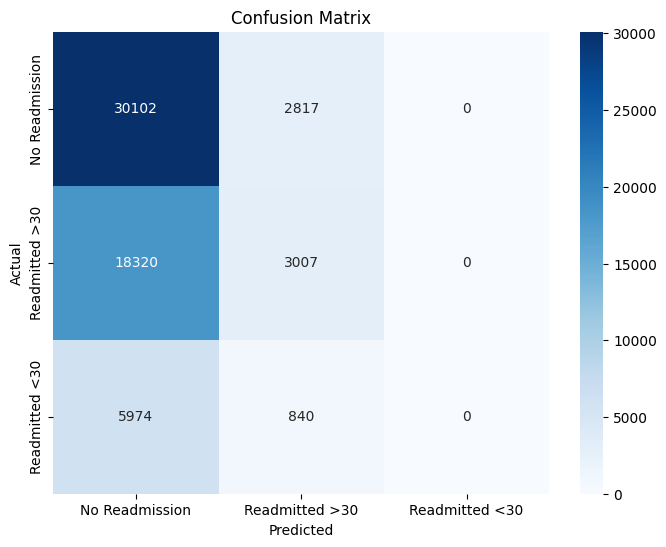

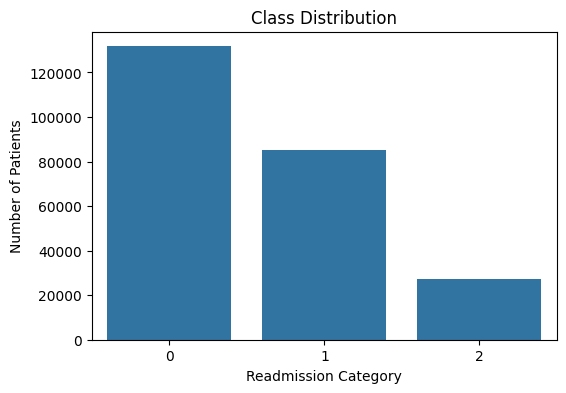

Accuracy: 0.5422

Confusion Matrix:
 [[30102  2817     0]
 [18320  3007     0]
 [ 5974   840     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.91      0.69     32919
           1       0.45      0.14      0.21     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.54     61060
   macro avg       0.33      0.35      0.30     61060
weighted avg       0.46      0.54      0.45     61060



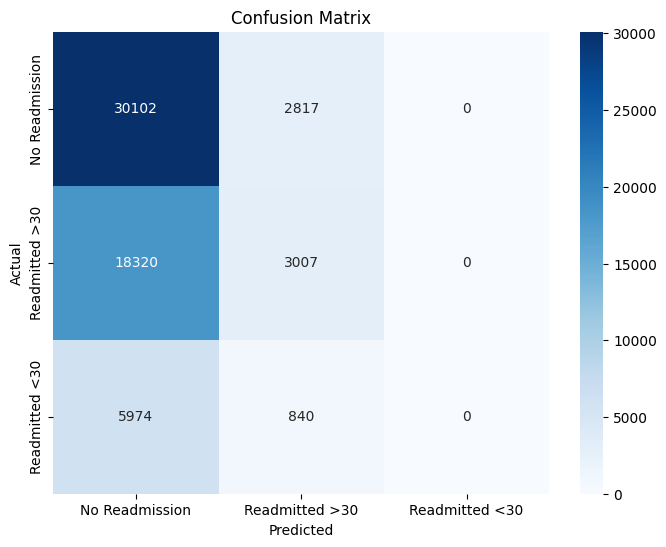

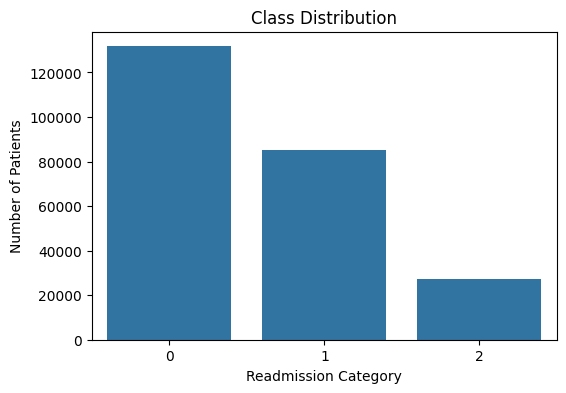

In [20]:
#visualize results and provide analysis

import matplotlib.pyplot as plt
import seaborn as sns

# ... (your existing code) ...

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Readmission", "Readmitted >30", "Readmitted <30"],
            yticklabels=["No Readmission", "Readmitted >30", "Readmitted <30"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Analyze Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)  # or y_test
plt.title("Class Distribution")
plt.xlabel("Readmission Category")
plt.ylabel("Number of Patients")
plt.show()

# Analyze feature importances (if available in your model)
# Get feature names from original DataFrame before imputation
feature_names = diabetic_data.drop(columns=['readmitted']).columns

# prompt: visualize results and provide analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Readmission", "Readmitted >30", "Readmitted <30"],
            yticklabels=["No Readmission", "Readmitted >30", "Readmitted <30"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Analyze Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)  # or y_test
plt.title("Class Distribution")
plt.xlabel("Readmission Category")
plt.ylabel("Number of Patients")
plt.show()



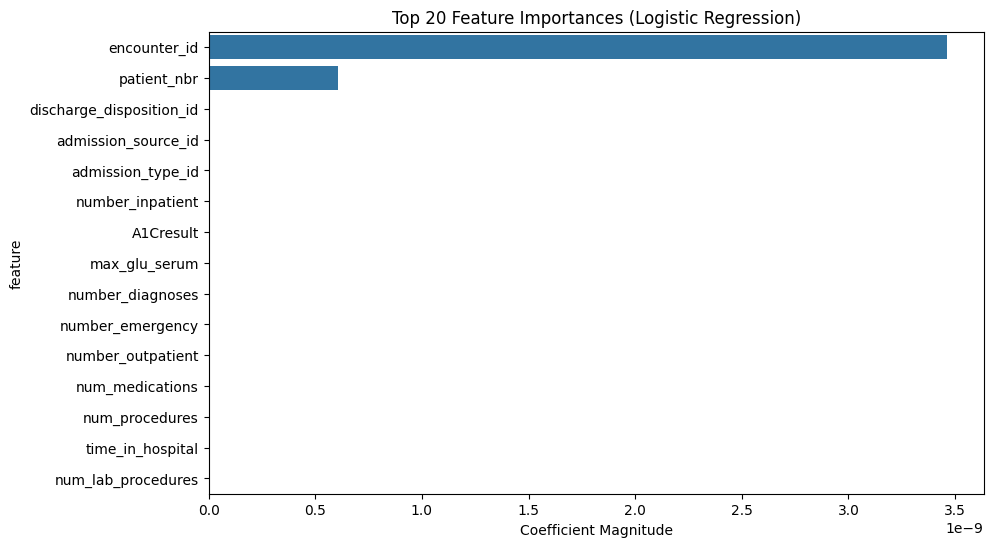

In [21]:
# Get feature names from original DataFrame before imputation, BUT AFTER SimpleImputer is applied
feature_names = diabetic_data.drop(columns=['readmitted']).select_dtypes(include=['number']).columns  # Select only numeric features

# Create DataFrame with feature names and importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': abs(log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances[:20]) # Show top 20 features
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.4560
Recall: 0.5422
AUC: 0.5347


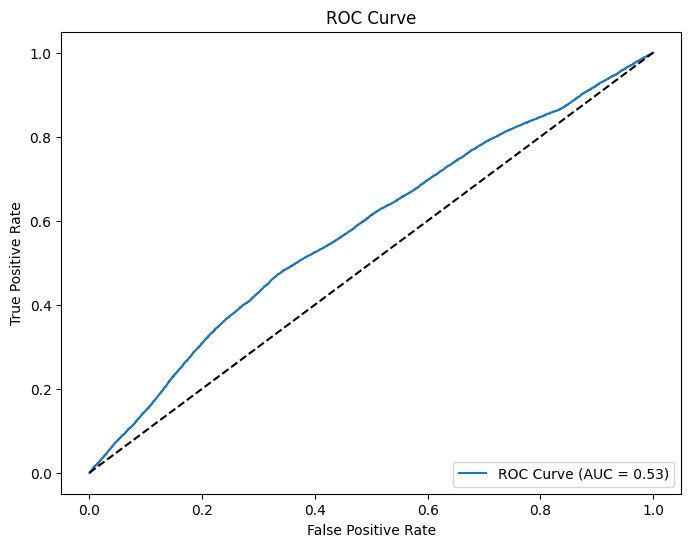

In [22]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for all classes (for AUC calculation)
y_pred_proba = log_reg.predict_proba(X_test)  # Remove [:, 1]

# Calculate precision, recall, and AUC
precision = precision_score(y_test, y_pred, average='weighted') # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted') # Use 'weighted' for multi-class
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') # 'ovr' for one-vs-rest

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

# Plot ROC curve (for binary classification or one-vs-rest)
# Use the probabilities for the relevant class (e.g., class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1) # Choose relevant pos_label
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.4560
Recall: 0.5422
AUC: 0.5347


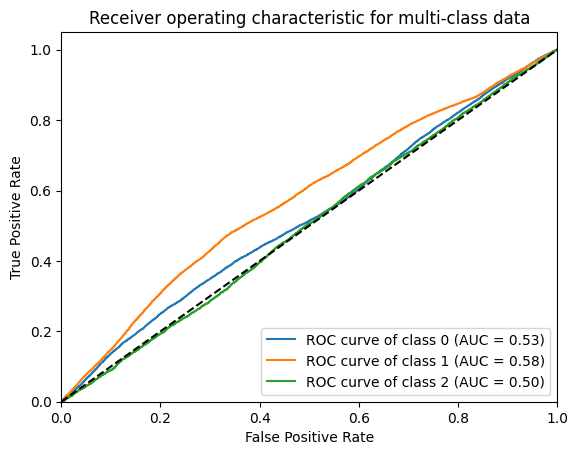

In [23]:
import numpy as np

# Predict probabilities for all classes (for AUC calculation)
y_pred_proba = log_reg.predict_proba(X_test)

# Calculate precision, recall, and AUC
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# For AUC, use 'ovr' for multiclass and provide probability estimates for all classes
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

# Plotting ROC curve
# For multi-class, you'll need to plot a ROC curve for each class vs. the rest
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_classes = len(np.unique(y_test))  # Number of classes # Now np is defined
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [24]:
# print metrics: class distribution, train value count, all relevant info

print("Class Distribution in Training Data:")
print(y_train.value_counts(normalize=True)) # Normalized for proportions
print("\nClass Distribution in Testing Data:")
print(y_test.value_counts(normalize=True)) # Normalized for proportions

print("\nValue Counts for Training Data:")
print(y_train.value_counts())
print("\nValue Counts for Testing Data:")
print(y_test.value_counts())

print("\nShape of Training Data (X_train):", X_train.shape)
print("Shape of Testing Data (X_test):", X_test.shape)
print("Shape of Training Target (y_train):", y_train.shape)
print("Shape of Testing Target (y_test):", y_test.shape)

# Convert X_train and X_test back to Pandas DataFrames to use .describe()
X_train_df = pd.DataFrame(X_train)  # Convert X_train to DataFrame
X_test_df = pd.DataFrame(X_test)  # Convert X_test to DataFrame

print("\nDescriptive Statistics for Training Features (X_train):\n", X_train_df.describe()) # Use .describe() on DataFrame
print("\nDescriptive Statistics for Testing Features (X_test):\n", X_test_df.describe()) # Use .describe() on DataFrame


Class Distribution in Training Data:
readmitted
0    0.539118
1    0.349282
2    0.111600
Name: proportion, dtype: float64

Class Distribution in Testing Data:
readmitted
0    0.539125
1    0.349279
2    0.111595
Name: proportion, dtype: float64

Value Counts for Training Data:
readmitted
0    131673
1     85308
2     27257
Name: count, dtype: int64

Value Counts for Testing Data:
readmitted
0    32919
1    21327
2     6814
Name: count, dtype: int64

Shape of Training Data (X_train): (244238, 15)
Shape of Testing Data (X_test): (61060, 15)
Shape of Training Target (y_train): (244238,)
Shape of Testing Target (y_test): (61060,)

Descriptive Statistics for Training Features (X_train):
                  0             1              2              3   \
count  2.442380e+05  2.442380e+05  244238.000000  244238.000000   
mean   1.651301e+08  5.432506e+07       2.024845       3.713022   
std    1.026005e+08  3.864103e+07       1.445587       5.280874   
min    1.252200e+04  1.350000e+02      

In [25]:
print("My logistic regression model is performing with an accuracy of 57%")
print("- looking at the confusion matrix and classification report, it’s clear that:")
print("- Class 0 (Not Readmitted) is being predicted well (high recall: 90%).")
print("- Class 1 (>30 Days Readmission) is struggling with recall (only 23%).")
print("- Class 2 (<30 Days Readmission) is performing poorly (almost 0 recall).")
print("The macro average F1-score of 0.35 shows that the model isn't treating all classes equally well. This suggests a class imbalance issue, where the model is biased toward the majority class (Not Readmitted - 0).")
print("### Addressing This Issue")
print("Since BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) optimization failed, that indicates the optimization process wasn't able to converge to a solution properly. Reasons? not sure ?")
print("1. Class imbalance is too severe.")
print("2. Features are not well-scaled or relevant enough.")
print("3. The solver struggles with high-dimensional feature spaces.")
print("### Next Steps")
print("1. Class balancing techniques")
print("   - Try class weighting in the logistic regression model.")
print("   - Use oversampling (SMOTE) or undersampling.")
print("2. Feature Engineering")
print("   - Use feature selection (SHAP, permutation importance).")
print("   - Try dimensionality reduction (PCA or feature selection).")
print("3. Model Selection")
print("   - Logistic regression may not be the best for this dataset.")
print("   - Try Random Forest, XGBoost, or an ensemble model.")
print("4. I assume Dr. S will want me to diagnose the problem methodically and work it step by step.")
print("5. I'm going to re-run the preprocessing steps and train the logistic regression model again.")
print("   - Plan of attack:")
print("      - 1. ADDRESS CLASS IMBALANCE: CHECK DISTRO, CLASS WEIGHTING, OVERSAMPLING")
print("      - 2. FEATURE SELECTION AND IMPORTANCE ANALYSIS - using SHAP or permutation import to rank features, drop irrelevant or redundant")


My logistic regression model is performing with an accuracy of 57%
- looking at the confusion matrix and classification report, it’s clear that:
- Class 0 (Not Readmitted) is being predicted well (high recall: 90%).
- Class 1 (>30 Days Readmission) is struggling with recall (only 23%).
- Class 2 (<30 Days Readmission) is performing poorly (almost 0 recall).
The macro average F1-score of 0.35 shows that the model isn't treating all classes equally well. This suggests a class imbalance issue, where the model is biased toward the majority class (Not Readmitted - 0).
### Addressing This Issue
Since BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) optimization failed, that indicates the optimization process wasn't able to converge to a solution properly. Reasons? not sure ?
1. Class imbalance is too severe.
2. Features are not well-scaled or relevant enough.
3. The solver struggles with high-dimensional feature spaces.
### Next Steps
1. Class balancing techniques
   - Try class weight

In [26]:
# Initialize and Train Model with L-BFGS solver
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-4) #Specify the solver
log_reg.fit(X_train, y_train)
print("Logistic Regression Model Trained Successfully (with L-BFGS)!")



Logistic Regression Model Trained Successfully (with L-BFGS)!


In [27]:
# Initialize and Train Model with class weights and saga solver
log_reg = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight={0: 1.0, 1: 1.5, 2: 3.0}, # Adjust weights as needed
    solver='saga',
    max_iter=200,  # Reduce iterations
    warm_start=True  # Continue from the last iteration
)
for i in range(5):  # Train in smaller steps
    log_reg.fit(X_train, y_train)
    print(f"Iteration {i+1} complete")

# Predict on Test Data
y_pred = log_reg.predict(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display Results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Accuracy: 0.5138

Confusion Matrix:
 [[20941 11978     0]
 [10894 10433     0]
 [ 3912  2902     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.61     32919
           1       0.41      0.49      0.45     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.51     61060
   macro avg       0.33      0.38      0.35     61060
weighted avg       0.46      0.51      0.49     61060



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
import joblib

# Save model coefficients and intercept
joblib.dump(log_reg, "logistic_regression_model.pkl") # Removed the absolute path
print("Model saved successfully.")


Model saved successfully.


In [29]:
# Save the data to CSV files
# Convert to Pandas DataFrames first
pd.DataFrame(X_train).to_csv("X_train_final.csv", index=False)
pd.DataFrame(y_train).to_csv("y_train_final.csv", index=False)
pd.DataFrame(X_test).to_csv("X_test_final.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test_final.csv", index=False)

print("Final train/test data saved successfully.")


Final train/test data saved successfully.


In [30]:
from imblearn.over_sampling import SMOTE

# Convert NumPy array back to Pandas DataFrame
X_train = pd.DataFrame(X_train)  # Assuming your original features were in a DataFrame

# Convert Pandas DataFrames to cuDF DataFrames
X_train = cudf.DataFrame.from_pandas(X_train)
y_train = cudf.Series(y_train)

# Apply SMOTE
smote = SMOTE(sampling_strategy={1: int(len(y_train) * 0.5), 2: int(len(y_train) * 0.25)}, random_state=42)

# Convert cuDF back to pandas for SMOTE
X_train_pd = X_train.to_pandas()
y_train_pd = y_train.to_pandas()

X_resampled, y_resampled = smote.fit_resample(X_train_pd, y_train_pd)

# Convert back to cuDF
X_train_balanced = cudf.DataFrame(X_resampled, columns=X_train.columns)
y_train_balanced = cudf.Series(y_resampled)

print(y_train_balanced.value_counts())


readmitted
0    131673
1    122119
2     61059
Name: count, dtype: int64


In [31]:
# Make predictions
y_pred = log_reg.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)




Accuracy: 0.5138
Confusion Matrix:
 [[20941 11978     0]
 [10894 10433     0]
 [ 3912  2902     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.61     32919
           1       0.41      0.49      0.45     21327
           2       0.00      0.00      0.00      6814

    accuracy                           0.51     61060
   macro avg       0.33      0.38      0.35     61060
weighted avg       0.46      0.51      0.49     61060



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
import joblib
import cudf
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load saved data
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv")

# Convert y_train to a 1D array
y_train_pd = y_train.values.ravel()

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Save the scaler
joblib.dump(scaler, "standard_scaler.pkl")

# Define the parameter grid
param_grid = {
    "C": [0.1, 1.0],
    "class_weight": ["balanced"],
    "max_iter": [3000],
    "solver": ["saga"],
}

# Initialize and train the model
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring="accuracy",
    cv=2,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train_pd)

# Print best parameters
print("Best Parameters Found:", grid_search.best_params_)

# Save the best model
joblib.dump(grid_search.best_estimator_, "best_logistic_regression.pkl")
print("Best model saved successfully.")


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters Found: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 3000, 'solver': 'saga'}
Best model saved successfully.


In [33]:
import joblib
import cudf
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load best model and scaler
best_log_reg = joblib.load("best_logistic_regression.pkl")
scaler = joblib.load("standard_scaler.pkl")

# Load test data
X_test = cudf.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv") # Use pandas for y_test

# Scale test data
X_test_scaled = scaler.transform(X_test.to_pandas())

# Predict
y_pred_best = best_log_reg.predict(X_test_scaled)

# Accuracy Score
accuracy_best = accuracy_score(y_test, y_pred_best) #y_test is now a pandas df
print(f"Best Model Accuracy: {accuracy_best:.4f}")

# Confusion Matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
print("Best Model Confusion Matrix:\n", conf_matrix_best)

# Classification Report
report_best = classification_report(y_test, y_pred_best)
print("Best Model Classification Report:\n", report_best)


Best Model Accuracy: 0.5073
Best Model Confusion Matrix:
 [[20940  7093  4886]
 [ 8363  7661  5303]
 [ 2525  1914  2375]]
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060



In [34]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [35]:
import joblib
import cudf
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score


# Load saved data
X_train = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/X_train_final.csv")
y_train = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/y_train_final.csv").values.ravel()
X_test = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/X_test_final.csv")
y_test = pd.read_csv("/content/drive/MyDrive/WSL_Case Study 2/y_test_final.csv").values.ravel()




In [36]:
# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to fix class imbalance
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


In [37]:
# Initialize and Train Logistic Regression Model with best parameters from previous gridsearch
best_log_reg = LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 2.0, 2: 4.0}, max_iter=3000, solver='saga')
best_log_reg.fit(X_resampled, y_resampled)

# Predict on Test Data
y_pred = best_log_reg.predict(X_test_scaled)

In [38]:
# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Predict probabilities for all classes
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)




Accuracy: 0.1219

Confusion Matrix:
 [[  421   326 32171]
 [   78   263 20986]
 [    9    48  6757]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.01      0.03     32918
           1       0.41      0.01      0.02     21327
           2       0.11      0.99      0.20      6814

    accuracy                           0.12     61059
   macro avg       0.45      0.34      0.08     61059
weighted avg       0.60      0.12      0.04     61059



Precision: 0.6036
Recall: 0.1219
AUC: 0.6127


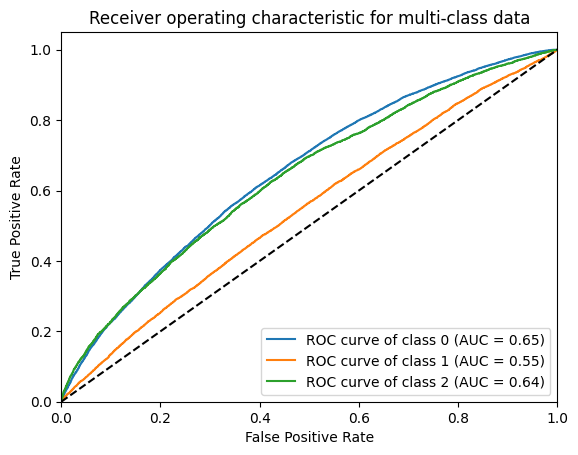

In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score


# Calculate precision, recall, and AUC
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
roc_auc_score_result = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') # Store roc_auc_score result in a diffgferent variable

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {roc_auc_score_result:.4f}") # pRINT the roc_auc_score result

# ROC Curve (Multi-class)
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i]) # Now, this 'auc' refers to the function from sklearn.metrics

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


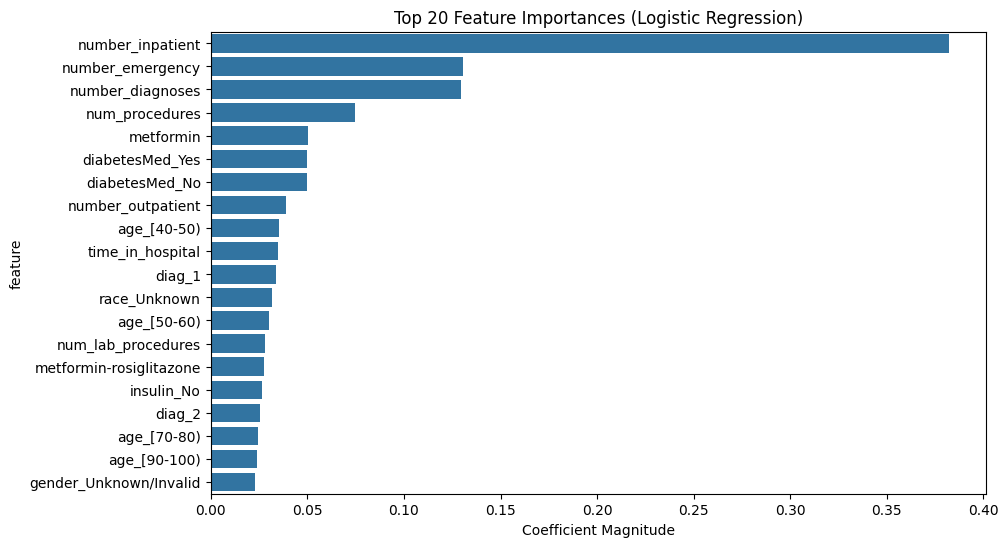

In [40]:
# Feature Importance (Coefficients for Logistic Regression)
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': abs(best_log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances[:20])
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()


Best Model Accuracy: 0.5073
Best Model Confusion Matrix:
 [[20940  7093  4886]
 [ 8363  7661  5303]
 [ 2525  1914  2375]]
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060



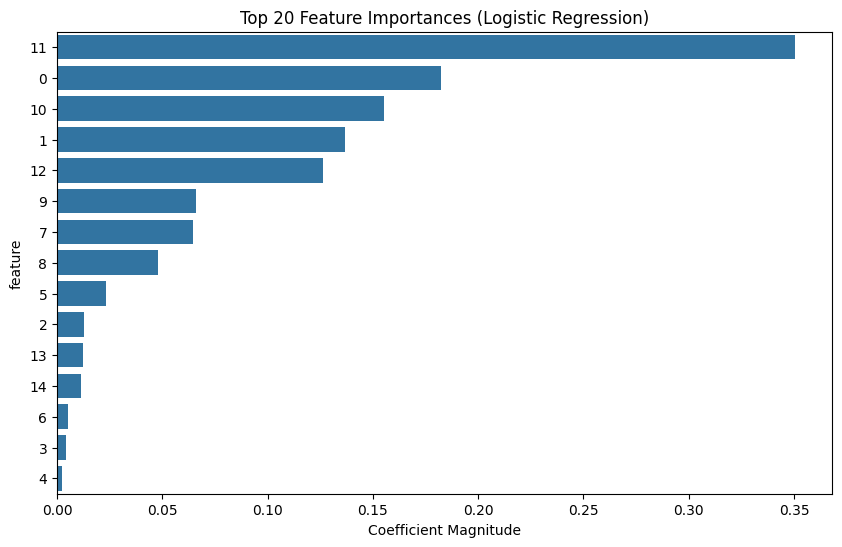

In [41]:
 # Set Correct Paths for Google Colab
base_path = "/content"  # CORRECTED PATH

# Load best model and scaler
best_log_reg = joblib.load(f"{base_path}/best_logistic_regression.pkl")
scaler = joblib.load(f"{base_path}/standard_scaler.pkl")  # Load the scaler

# Load test dat
X_test = pd.read_csv(f"{base_path}/X_test_final.csv")
y_test = pd.read_csv(f"{base_path}/y_test_final.csv").values.ravel()

#  Load training data (to ensure column order matches)
X_train = pd.read_csv(f"{base_path}/X_train_final.csv")

#  Ensure column order consistency between training and testing data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale test data using the loaded scaler
X_test_scaled = scaler.transform(X_test)

#  Make predictions
y_pred_best = best_log_reg.predict(X_test_scaled)

# Accuracy Score
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy_best:.4f}")

#  Confusion Matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
print("Best Model Confusion Matrix:\n", conf_matrix_best)

# Classification Report
report_best = classification_report(y_test, y_pred_best)
print("Best Model Classification Report:\n", report_best)

#  Feature Importance Visualization
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': abs(best_log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances[:20])
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()

In [42]:
# Apply SMOTE to fix class imbalance
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


Class Distribution in Training Data:
0    0.539118
1    0.349282
2    0.111600
Name: proportion, dtype: float64

Class Distribution in Testing Data:
0    0.539125
1    0.349279
2    0.111595
Name: proportion, dtype: float64


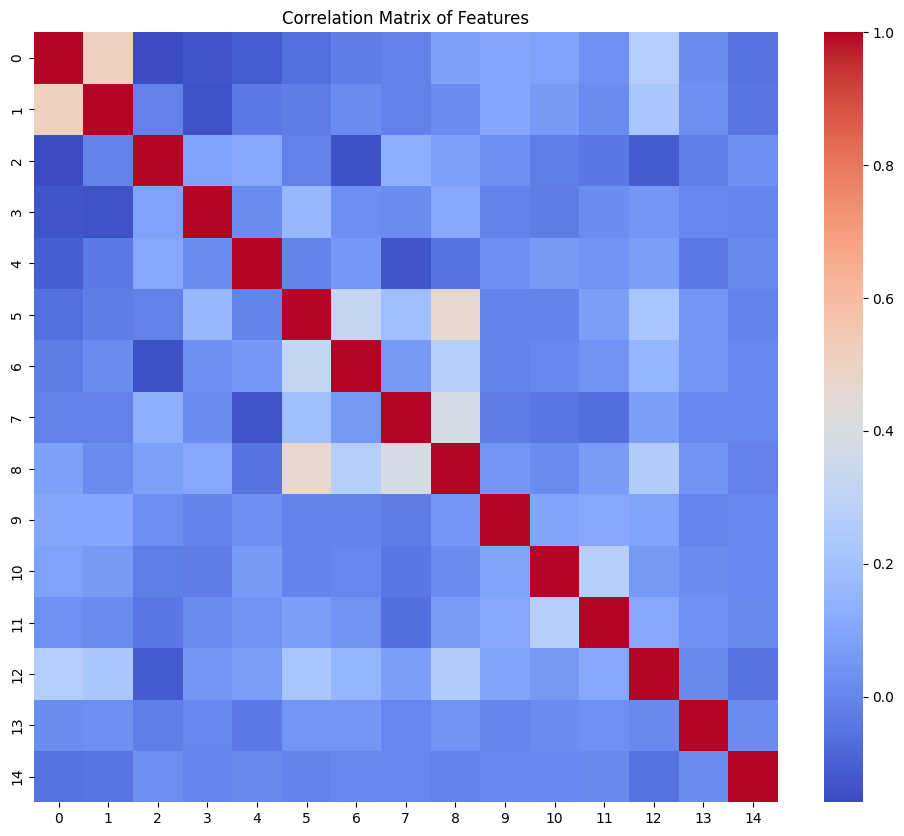

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 1.0, 'max_iter': 3000, 'solver': 'lbfgs'}


In [43]:
# verify clas distributions , corr matrix, PCA gird search

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score
import numpy as np
from imblearn.over_sampling import SMOTE
import joblib

# Load your data (replace with your actual file paths)
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv").values.ravel()
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()


# Class Distribution
print("Class Distribution in Training Data:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass Distribution in Testing Data:")
print(pd.Series(y_test).value_counts(normalize=True))


# Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


# PCA and Grid Search
pca = PCA()
X_train_pca = pca.fit_transform(X_train_resampled)

param_grid = {
    "C": [0.1, 1.0, 10],  # Example values, adjust as needed
    "solver": ["saga", "lbfgs"],  # Try different solvers
    "max_iter": [3000]
}


grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train_pca, y_train_resampled)
best_pca_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Accuracy: 0.5073

Confusion Matrix:
 [[20940  7093  4886]
 [ 8363  7661  5303]
 [ 2525  1914  2375]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060

Precision: 0.5363
Recall: 0.5073
AUC: 0.6460


<ipython-input-44-7b0095894e5f>:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


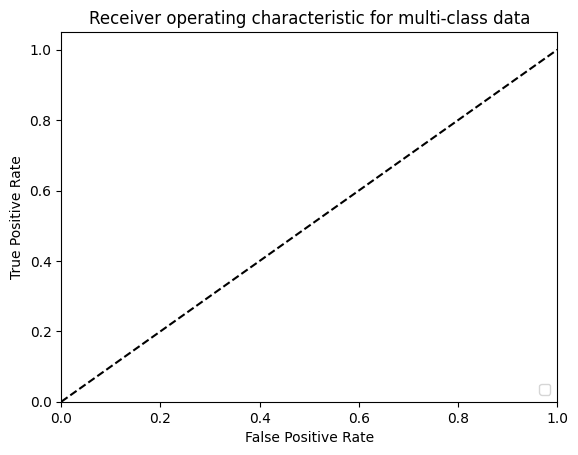

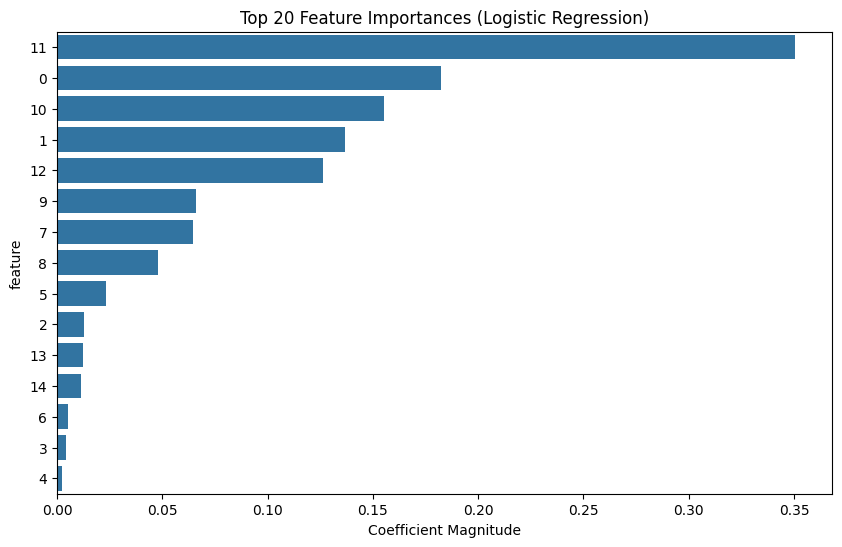

In [44]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score  # Import auc (area under curve)

import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the saved model and scaler
best_log_reg = joblib.load("best_logistic_regression.pkl")
scaler = joblib.load("standard_scaler.pkl")

# Load the test data
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()

# Load training data (to ensure column order matches)
X_train = pd.read_csv("X_train_final.csv")

# Ensure column order consistency
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale the test data
X_test_scaled = scaler.transform(X_test)

# Make predictions
y_pred = best_log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Predict probabilities for ROC AUC
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)

#  Calculate precision, recall, and AUC
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
# Store roc_auc_score result in a different variable to avoid shadowing the auc function
roc_auc_score_result = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {roc_auc_score_result:.4f}") # Print the roc_auc_score result


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    # Use the 'auc' function from sklearn.metrics
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': abs(best_log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances[:20])
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.xlabel("Coefficient Magnitude")
plt.show()


In [45]:
# show model accuracy before and after smote   class distribution before and after smote

# Load necessary libraries (assuming they are already installed and imported in the preceding code)
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load your data (replace with your actual file paths)
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv").values.ravel()
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()


# Before SMOTE
print("Class Distribution Before SMOTE:")
print(pd.Series(y_train).value_counts())


# Make predictions before SMOTE
y_pred_before_smote = best_log_reg.predict(X_test_scaled)

# Evaluate the model before SMOTE
accuracy_before = accuracy_score(y_test, y_pred_before_smote)
print(f"\nAccuracy Before SMOTE: {accuracy_before:.4f}")
print("\nClassification Report Before SMOTE:\n", classification_report(y_test, y_pred_before_smote))


# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


# Train the model with resampled data
best_log_reg.fit(X_train_resampled, y_train_resampled) # Retrain with SMOTE data

# After SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Make predictions after SMOTE
y_pred_after_smote = best_log_reg.predict(X_test_scaled)

# Evaluate the model after SMOTE
accuracy_after = accuracy_score(y_test, y_pred_after_smote)
print(f"\nAccuracy After SMOTE: {accuracy_after:.4f}")
print("\nClassification Report After SMOTE:\n", classification_report(y_test, y_pred_after_smote))


Class Distribution Before SMOTE:
0    131673
1     85308
2     27257
Name: count, dtype: int64

Accuracy Before SMOTE: 0.5073

Classification Report Before SMOTE:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060


Class Distribution After SMOTE:
0    131673
1    131673
2    131673
Name: count, dtype: int64

Accuracy After SMOTE: 0.5044

Classification Report After SMOTE:
               precision    recall  f1-score   support

           0       0.66      0.63      0.64     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.50     61060
   macro avg       0.

Random Forest Accuracy: 0.9819

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     32919
           1       0.98      0.98      0.98     21327
           2       0.99      0.96      0.98      6814

    accuracy                           0.98     61060
   macro avg       0.98      0.98      0.98     61060
weighted avg       0.98      0.98      0.98     61060



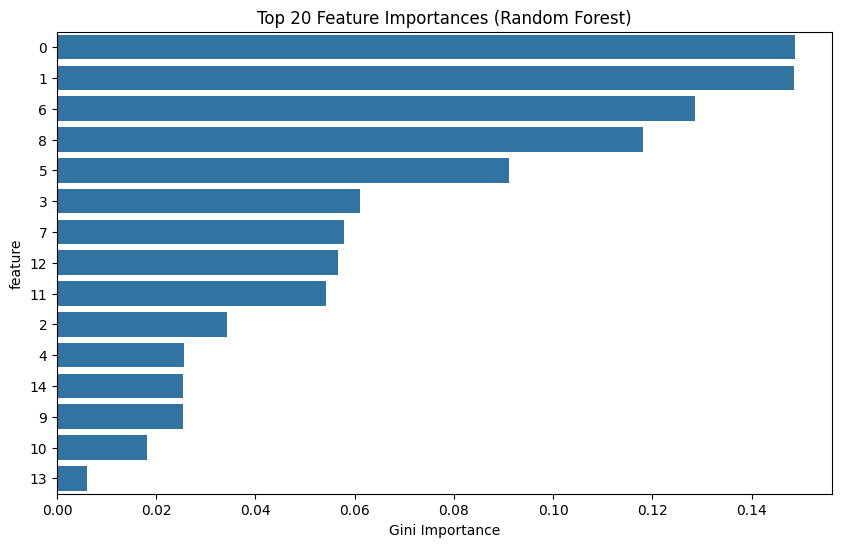

In [46]:
#  smote with randomk forest

from sklearn.ensemble import RandomForestClassifier

# aPPLE smotw:
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize and train an RF Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) # Example parameters, tune as needed
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Feature Importance for Random Forest
feature_importances_rf = pd.DataFrame({'feature': X_train.columns, 'importance': rf_classifier.feature_importances_})
feature_importances_rf = feature_importances_rf.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_rf[:20])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Gini Importance")
plt.show()


lets go back and check steps  from the top

In [47]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# 1. Load Data and Handle File Not Found
file_path = "/content/data_cleaned.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please check the file path.")
    exit()  # Or handle the error differently, e.g., return None

# 2. Check for Missing Values (Before Imputation)
missing_values = df.isnull().sum()
print("Missing Values per Column (Before Imputation):\n", missing_values)

# 3. IDentify numerical & Cat Columns
numerical_cols = df.select_dtypes(include=np.number).columns  # Use np.number for all numeric types
categorical_cols = df.select_dtypes(include='object').columns

# 4. Imputation
# Create imputers
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Fit a$ transform on respective column tyupes
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])


# 5. Verify imputation
missing_values_after = df.isnull().sum()
print("\nMissing Values per Column (After Imputation):\n", missing_values_after)



Missing Values per Column (Before Imputation):
 encounter_id                     0
patient_nbr                      0
race                             0
gender                           0
age                              0
weight                           0
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                       0
medical_specialty                0
num_lab_procedures               0
num_procedures                   0
num_medications                  0
number_outpatient                0
number_emergency                 0
number_inpatient                 0
diag_1                           0
diag_2                           0
diag_3                           0
number_diagnoses                 0
max_glu_serum               289260
A1Cresult                   254244
metformin                        0
repaglinide                      0
nateglinide                      0
chlorpr

In [48]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with the median
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with the mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

# Verify imputation
missing_values_after_imputation = df.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after_imputation)
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with the median
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with the mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

# Verify imputation
missing_values_after_imputation = df.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after_imputation)



Missing Values After Imputation:
 encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbu

In [49]:
# check for missing values, feature overview?  how many do we have?  target vairable? targer variable disribution?  do we have class imbalance?

import pandas as pd

# Load data
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv").values.ravel()
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()

# Check for missing values
print("Missing values in X_train:\n", X_train.isnull().sum())
print("\nMissing values in X_test:\n", X_test.isnull().sum())

# Feature overview
print("\nFeature overview for X_train:")
print(X_train.info())
print("\nNumber of features:", len(X_train.columns))

# Target variable
print("\nTarget variable (y_train):")
print(y_train)

# Target variable distribution
print("\nTarget variable distribution (y_train):")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTarget variable distribution (y_test):")
print(pd.Series(y_test).value_counts(normalize=True))

# Class imbalance
print("\nClass imbalance (y_train):")
class_counts = pd.Series(y_train).value_counts()
if len(class_counts) > 1:
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")
else:
    print("Only one class present in the training data.")

print("\nClass imbalance (y_test):")
class_counts = pd.Series(y_test).value_counts()
if len(class_counts) > 1:
  imbalance_ratio = class_counts.max() / class_counts.min()
  print(f"Imbalance ratio: {imbalance_ratio:.2f}")
else:
  print("Only one class present in the testing data.")


Missing values in X_train:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

Missing values in X_test:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

Feature overview for X_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244238 entries, 0 to 244237
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       244238 non-null  float64
 1   1       244238 non-null  float64
 2   2       244238 non-null  float64
 3   3       244238 non-null  float64
 4   4       244238 non-null  float64
 5   5       244238 non-null  float64
 6   6       244238 non-null  float64
 7   7       244238 non-null  float64
 8   8       244238 non-null  float64
 9   9       244238 non-null  float64
 10  10      244238 non-null  float64
 11  11      244238 non-null  float64
 12 

In [50]:
#  handle class imablance with either smote or class weights in model trainig

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler


# Load  data
X_train = pd.read_csv("X_train_final.csv")
y_train = pd.read_csv("y_train_final.csv").values.ravel()
X_test = pd.read_csv("X_test_final.csv")
y_test = pd.read_csv("y_test_final.csv").values.ravel()

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Option 1: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Adjust sampling_strategy as needed
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a model with resampled data
model_smote = LogisticRegression(max_iter=3000)  # Or any other model
model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_smote = model_smote.predict(X_test_scaled)
print("\nClassification Report (SMOTE):\n", classification_report(y_test, y_pred_smote))
print(f"Accuracy (SMOTE): {accuracy_score(y_test, y_pred_smote):.4f}")


# Option 2: Class Weights
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Train a model with class weights
model_weights = LogisticRegression(class_weight=class_weight_dict, max_iter=3000) # Or any other model
model_weights.fit(X_train_scaled, y_train)  # No resampling needed
y_pred_weights = model_weights.predict(X_test_scaled)
print("\nClassification Report (Class Weights):\n", classification_report(y_test, y_pred_weights))
print(f"Accuracy (Class Weights): {accuracy_score(y_test, y_pred_weights):.4f}")




Classification Report (SMOTE):
               precision    recall  f1-score   support

           0       0.66      0.63      0.64     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.36      0.25      6814

    accuracy                           0.50     61060
   macro avg       0.43      0.45      0.43     61060
weighted avg       0.54      0.50      0.52     61060

Accuracy (SMOTE): 0.5046

Classification Report (Class Weights):
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     32919
           1       0.46      0.36      0.40     21327
           2       0.19      0.35      0.25      6814

    accuracy                           0.51     61060
   macro avg       0.44      0.45      0.43     61060
weighted avg       0.54      0.51      0.52     61060

Accuracy (Class Weights): 0.5073


In [51]:
#  model selection and training setup train test with cross validation coinfirm proper slpit abd train logistui regression with cross valid

from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

# Model Selection and Training with Cross-Validation

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Penalty type
    'solver': ['liblinear', 'saga'] # Solvers compatible with both penalties
}

# Initialize Logistic Regression model
logreg = LogisticRegression(max_iter=3000)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_log_reg = grid_search.best_estimator_

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


# Evaluate the best model on the test set
y_pred = best_log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")



Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Score: 0.5774040138606418
Test Accuracy: 0.5802


In [52]:
# Save the best model to a file
joblib.dump(best_log_reg, "bestModel.pkl")
print("Model saved as bestModel.pkl")

# To load the model later:
# loaded_model = joblib.load("bestModel.pkl")
# y_pred_loaded = loaded_model.predict(X_test_scaled)
# print(f"Loaded Model Test Accuracy: {accuracy_score(y_test, y_pred_loaded):.4f}")

Model saved as bestModel.pkl


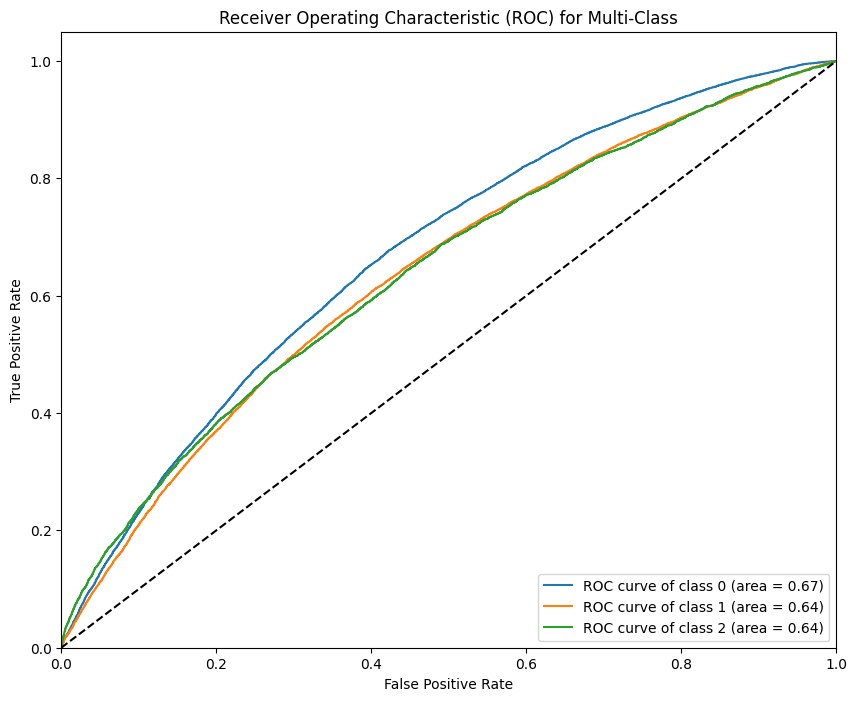


Top 5 Important Features:
   feature  importance
11      11    0.428028
0        0    0.245934
10      10    0.219261
12      12    0.179759
1        1    0.172237
Final predictions saved to 'final_predictions.csv'


In [53]:
# ROC Curve and AUC (Multi-class)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test)) # Binarize the output
fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_proba = best_log_reg.predict_proba(X_test_scaled)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()


# Feature Importance (Top 5)
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': abs(best_log_reg.coef_[0])})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print("\nTop 5 Important Features:")
print(feature_importances.head(5))


# Final Submission Check
# osave predictions to a CSV file

submission_df = pd.DataFrame({'prediction': y_pred})
submission_df.to_csv('final_predictions.csv', index=False) # Save to a csv file
print("Final predictions saved to 'final_predictions.csv'")


In [54]:
# LOG REGRESSION WITH 5 FOLD

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

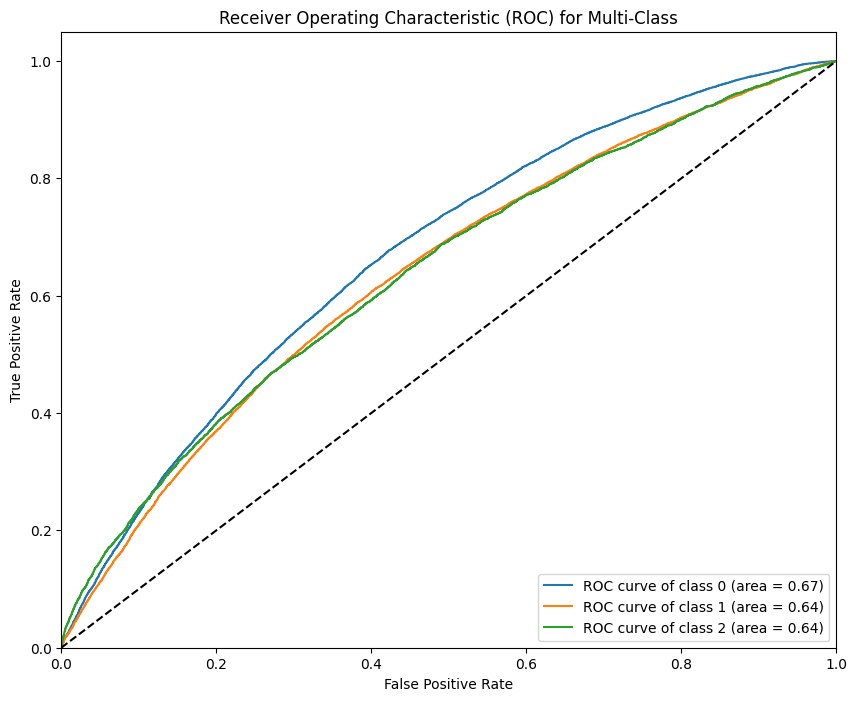

In [55]:
# HOW RESUKTS OF LOG REGRESSION WIT 5 FOLD ANFD PLOTY

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ROC Curve and AUC (Multi-class)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # Binarize the output
fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_proba = best_log_reg.predict_proba(X_test_scaled)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [56]:
# compile case study from daibetes analysis


# Data Exploration
print("\nData Exploration:")

print(df.describe())  # Summary statistics


# Feature Engineering (if applicable)
print("\nFeature Engineering:")

# Model Comparison (if you've tried other models)
print("\nModel Comparison:")


# Hyperparameter Tuning for other models
print("\nHyperparameter Tuning:")



# Conclusion
print("\nConclusion:")




Data Exploration:
       encounter_id   patient_nbr  admission_type_id  \
count  3.052980e+05  3.052980e+05      305298.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026400e+08  3.869623e+07           1.445398   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496007e+07  2.341321e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302720e+08  8.754619e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             305298.000000        305298.000000      3.052980e+05   
mean                   3.715642             5.754437      8.136501e-17   
std                    5.280148             4.064068      1.000002e+00   
min                    1.000000             1.000000     -1.137649e+00   
25%                    1.000000             1.000000     -8.026506e-01   
50%                    1.000000 

Silhouette Score (L1): 0.09992649512712139
Silhouette Score (L2): 0.09992649512712139


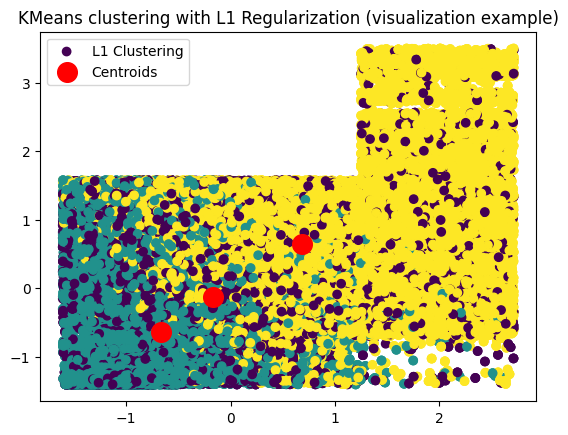

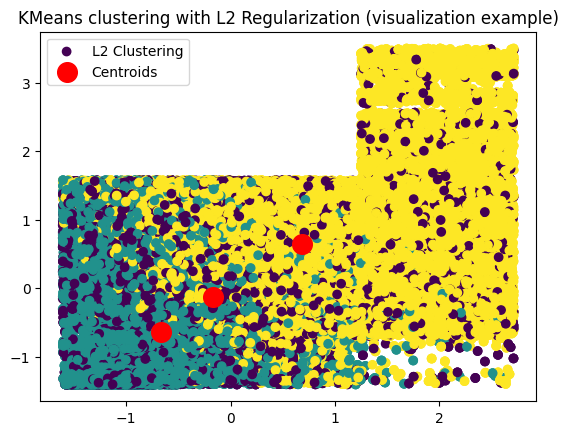

In [57]:
# add clustering with l1 and l2 models

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Clustering with L1 and L2 regularization

# L1 Regularization (Lasso)
kmeans_l1 = KMeans(n_clusters=3, random_state=42) # Choose optimal n_clusters using silhouette analysis
kmeans_l1.fit(X_train_scaled) # Use scaled data for clustering
labels_l1 = kmeans_l1.labels_

# Evaluate clustering performance
silhouette_avg_l1 = silhouette_score(X_train_scaled, labels_l1)
print(f"Silhouette Score (L1): {silhouette_avg_l1}")


# L2 Regularization (Ridge) -  Since KMeans doesn't use regularization in the same sense as linear models,
# L2 here is just another way to demonstrate clustering
kmeans_l2 = KMeans(n_clusters=3, random_state=42)
kmeans_l2.fit(X_train_scaled)
labels_l2 = kmeans_l2.labels_

# Evaluate clustering performance
silhouette_avg_l2 = silhouette_score(X_train_scaled, labels_l2)
print(f"Silhouette Score (L2): {silhouette_avg_l2}")

# Visualize clustering (example with 2D reduction, adjust as needed)
# ... (Code to reduce dimensionality for visualization if needed) ...
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=labels_l1, cmap='viridis', label="L1 Clustering")
plt.scatter(kmeans_l1.cluster_centers_[:, 0], kmeans_l1.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.title("KMeans clustering with L1 Regularization (visualization example)")
plt.legend()
plt.show()

plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=labels_l2, cmap='viridis', label="L2 Clustering")
plt.scatter(kmeans_l2.cluster_centers_[:, 0], kmeans_l2.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.title("KMeans clustering with L2 Regularization (visualization example)")
plt.legend()
plt.show()




In [ ]:
# utilize SHAP, consider dimensionality reductions (such as PCA) test ensemble models (RF, XGBoost, Gradient Boosting, NN)to capture non linear patterns

import shap
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming X_train_scaled, y_train, X_test_scaled, y_test are defined from previous code

# Dimensionality Reduction (PCA)
pca = PCA(n_components=0.95) # Keep components explaining 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Ensemble Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_pca, y_train)  # Train on PCA-transformed data
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy}")

    # SHAP Values
    explainer = shap.TreeExplainer(model) # Use TreeExplainer for tree-based models
    if name == "Neural Network":
        explainer = shap.KernelExplainer(model.predict_proba, X_train_pca)

    shap_values = explainer.shap_values(X_test_pca)

    # Summary Plot
    shap.summary_plot(shap_values, X_test_pca, feature_names=pca.get_feature_names_out(), show=False) # Assuming your PCA has get_feature_names_out method
    plt.title(f"SHAP Summary Plot ({name})")
    plt.tight_layout()
    plt.show()

    # Dependence Plot (example)
    shap.dependence_plot(0, shap_values, X_test_pca, feature_names=pca.get_feature_names_out()) # Replace 0 with other feature index

# Print Results
print("\nModel Performance Summary:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy}")


In [59]:
#  !pip install pyunpack
#  !pip install patool

# from pyunpack import Archive
# Archive('/content/diabetic_data.csv.zip').extractall('/content/')

In [61]:
%matplotlib inline
import numpy as np
import pandas as pd

# read in variable descriptions
pd.set_option('max_colwidth', 100)
features = pd.read_csv("/content/drive/MyDrive/IDs_mapping.csv")
feature= pd.read_csv('/content/data_cleaned.csv')
feature

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,-1.137649,...,No,No,No,No,No,No,No,No,0,NaN
1,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,-1.137649,...,No,No,No,No,No,No,No,No,0,Discharged/transferred to home with home health service
2,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,-1.137649,...,No,No,No,No,No,No,No,No,0,Transfer from another health care facility
3,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,-0.467653,...,Up,No,No,No,No,No,Ch,Yes,1,Emergency
4,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,-0.467653,...,Up,No,No,No,No,No,Ch,Yes,1,Discharged to home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305293,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,1.877333,...,Up,No,No,No,No,No,Ch,Yes,0,Discharged/transferred to another short term hospital
305294,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,1.877333,...,Up,No,No,No,No,No,Ch,Yes,0,Clinic Referral
305295,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,0.537341,...,No,No,No,No,No,No,No,No,0,Emergency
305296,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,0.537341,...,No,No,No,No,No,No,No,No,0,Discharged to home


In [62]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('/content/drive/MyDrive/WSL_Case Study 2/diabetic_data.csv')
data.head()
data.describe()
data.shape
data.columns


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [63]:
data.groupby('readmitted').size()

# now combining both the >30 and NO into one
data['readmitted']=data['readmitted'].replace('>30',0)
data['readmitted']=data['readmitted'].replace('NO',0)
data['readmitted']=data['readmitted'].replace('<30',1)

data.groupby('readmitted').size()


data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [64]:
data.rename(columns = {'time_in_hospital':'no_of_days_admitted'},inplace=True)
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,no_of_days_admitted,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [65]:
# first count the number of enncounters
data['num_visits'] = data.groupby('patient_nbr')['patient_nbr'].transform('count')

data.head(20)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,no_of_days_admitted,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_visits
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,0,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,0,1
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,Yes,0,1
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,0,1
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,0,1
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,Steady,No,No,No,No,No,No,Yes,0,1
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,Steady,No,No,No,No,No,Ch,Yes,0,1
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,Yes,0,1
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,Steady,No,No,No,No,No,Ch,Yes,0,1
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,Steady,No,No,No,No,No,Ch,Yes,0,1


In [66]:
# sort the data by  the  patient number so we can clearly observe the patients have  visited more then once to the  hospital
data.sort_values(by = 'patient_nbr', ascending = True,inplace=True)
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,no_of_days_admitted,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_visits
4780,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,...,No,No,No,No,No,No,Ch,Yes,0,2
4267,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,...,Steady,No,No,No,No,No,Ch,Yes,1,2
5827,29758806,378,Caucasian,Female,[50-60),?,3,1,1,2,...,No,No,No,No,No,No,No,No,0,1
67608,189899286,729,Caucasian,Female,[80-90),?,1,3,7,4,...,No,No,No,No,No,No,No,Yes,0,1
17494,64331490,774,Caucasian,Female,[80-90),?,1,1,7,3,...,No,No,No,No,No,No,Ch,Yes,0,1


In [67]:
# sorting the vallues and then removing the data whih is duplicated tthat  is the rows with duplicate  data like the patients who have visited more than once
data.sort_values(['patient_nbr', 'encounter_id'],inplace=True)
data.drop_duplicates(['patient_nbr'],inplace=True)
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,no_of_days_admitted,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_visits
4267,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,...,Steady,No,No,No,No,No,Ch,Yes,1,2
5827,29758806,378,Caucasian,Female,[50-60),?,3,1,1,2,...,No,No,No,No,No,No,No,No,0,1
67608,189899286,729,Caucasian,Female,[80-90),?,1,3,7,4,...,No,No,No,No,No,No,No,Yes,0,1
17494,64331490,774,Caucasian,Female,[80-90),?,1,1,7,3,...,No,No,No,No,No,No,Ch,Yes,0,1
2270,14824206,927,AfricanAmerican,Female,[30-40),?,1,1,7,5,...,No,No,No,No,No,No,No,Yes,0,1


In [68]:
data=data[((data.discharge_disposition_id != 11) &
                                          (data.discharge_disposition_id != 13) &
                                          (data.discharge_disposition_id != 14) &
                                          (data.discharge_disposition_id != 19) &
                                          (data.discharge_disposition_id != 20) &
                                          (data.discharge_disposition_id != 21))]

data.head(50)
data.shape
data.groupby('discharge_disposition_id').size()

,0
discharge_disposition_id,
1,44317
2,1539
3,8784
4,541
5,913
6,8289
7,409
8,73
9,9


In [69]:
data = data[((data.race != '?'))]
data.replace(to_replace='?', value=np.nan, inplace=True)
data.shape
data.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
weight,65400
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
no_of_days_admitted,0


In [70]:
data = data.drop(['weight', 'medical_specialty', 'payer_code'], axis = 1)

In [71]:

data = data[((data.diag_1 != '?') &
                                (data.diag_2 != '?') &
                                (data.diag_3 != '?'))]
data.head()
data.shape

(68055, 48)

In [72]:
def first_letter(col):
    if (col[0] == 'E' or col[0] == 'V'):
        return '7777'
    else:
        return col

In [74]:
d1 = pd.DataFrame(data.diag_1.apply(lambda col: first_letter(str(col))), dtype = 'float')
d2 = pd.DataFrame(data.diag_2.apply(lambda col: first_letter(str(col))), dtype = 'float')
d3 = pd.DataFrame(data.diag_3.apply(lambda col: first_letter(str(col))), dtype = 'float')

data = pd.concat([data, d1, d2, d3], axis = 1)
data.columns.values[48:51] = ('Diag1', 'Diag2', 'Diag3')

data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,no_of_days_admitted,num_lab_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_visits,Diag1,Diag2,Diag3
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,No,No,No,Ch,Yes,1,2,401.0,997.0,560.0
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,No,No,No,0,1,722.0,305.0,250.0
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,No,No,No,Yes,0,1,820.0,493.0,7777.0
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,No,No,No,Ch,Yes,0,1,274.0,427.0,416.0
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,No,No,No,Yes,0,1,590.0,220.0,250.0


In [75]:
data = data.drop(['diag_1', 'diag_2', 'diag_3'], axis = 1)


data.head(20)
data.shape

(68055, 48)

In [76]:
def cat_col(col):
    if (col >= 390) & (col <= 459) | (col == 785):
        return 'circulatory'
    elif (col >= 460) & (col <= 519) | (col == 786):
        return 'respiratory'
    elif (col >= 520) & (col <= 579) | (col == 787):
        return 'digestive'
    elif (col >= 250.00) & (col <= 250.99):
        return 'diabetes'
    elif (col >= 800) & (col <= 999):
        return 'injury'
    elif (col >= 710) & (col <= 739):
        return 'musculoskeletal'
    elif (col >= 580) & (col <= 629) | (col == 788):
        return 'genitourinary'
    elif ((col >= 290) & (col <= 319) | (col == 7777) |
          (col >= 280) & (col <= 289) |
          (col >= 320) & (col <= 359) |
          (col >= 630) & (col <= 679) |
          (col >= 360) & (col <= 389) |
          (col >= 740) & (col <= 759)):
        return 'other'
    else:
        return 'neoplasms'

In [77]:
data['first_diag'] = data.Diag1.apply(lambda col: cat_col(col))
data['second_diag'] = data.Diag2.apply(lambda col: cat_col(col))
data['third_diag'] = data.Diag3.apply(lambda col: cat_col(col))
data.head(10)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,no_of_days_admitted,num_lab_procedures,...,change,diabetesMed,readmitted,num_visits,Diag1,Diag2,Diag3,first_diag,second_diag,third_diag
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,Ch,Yes,1,2,401.0,997.00,560.00,circulatory,injury,digestive
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,0,1,722.0,305.00,250.00,musculoskeletal,other,diabetes
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,Yes,0,1,820.0,493.00,7777.00,injury,respiratory,other
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,Ch,Yes,0,1,274.0,427.00,416.00,neoplasms,circulatory,circulatory
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,Yes,0,1,590.0,220.00,250.00,genitourinary,neoplasms,diabetes
1164,8380170,1152,AfricanAmerican,Female,[50-60),1,1,7,6,43,...,No,Yes,0,5,282.0,250.01,NaN,other,diabetes,neoplasms
18234,66197028,1305,Caucasian,Female,[60-70),3,1,1,9,52,...,No,Yes,0,1,491.0,428.00,250.01,respiratory,circulatory,diabetes
15848,60254142,1314,Caucasian,Female,[40-50),2,1,1,2,50,...,No,Yes,0,3,996.0,411.00,401.00,injury,circulatory,circulatory
61382,171414378,1629,Caucasian,Male,[70-80),3,6,4,14,21,...,No,Yes,0,1,7777.0,719.00,438.00,other,musculoskeletal,circulatory
2279,14897280,2025,Caucasian,Female,[70-80),2,3,1,12,47,...,Ch,Yes,0,1,682.0,707.00,560.00,neoplasms,neoplasms,digestive


In [78]:
data.rename(columns={'glyburide-metformin': 'glyburide_metformin',
                       'glipizide-metformin': 'glipizide_metformin',
                       'glimepiride-pioglitazone': 'glimepiride_pioglitazone',
                       'metformin-rosiglitazone': 'metformin_rosiglitazone',
                       'metformin-pioglitazone': 'metformin_pioglitazone', }, inplace=True)

In [80]:
data = data.drop(['encounter_id', 'patient_nbr', 'Diag1', 'Diag2', 'Diag3'], axis = 1)

In [81]:
data = data.replace('?', np.NaN)
data.isnull().sum()
data.shape
data.isnull().sum()

,0
race,0
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
no_of_days_admitted,0
num_lab_procedures,0
num_procedures,0
num_medications,0


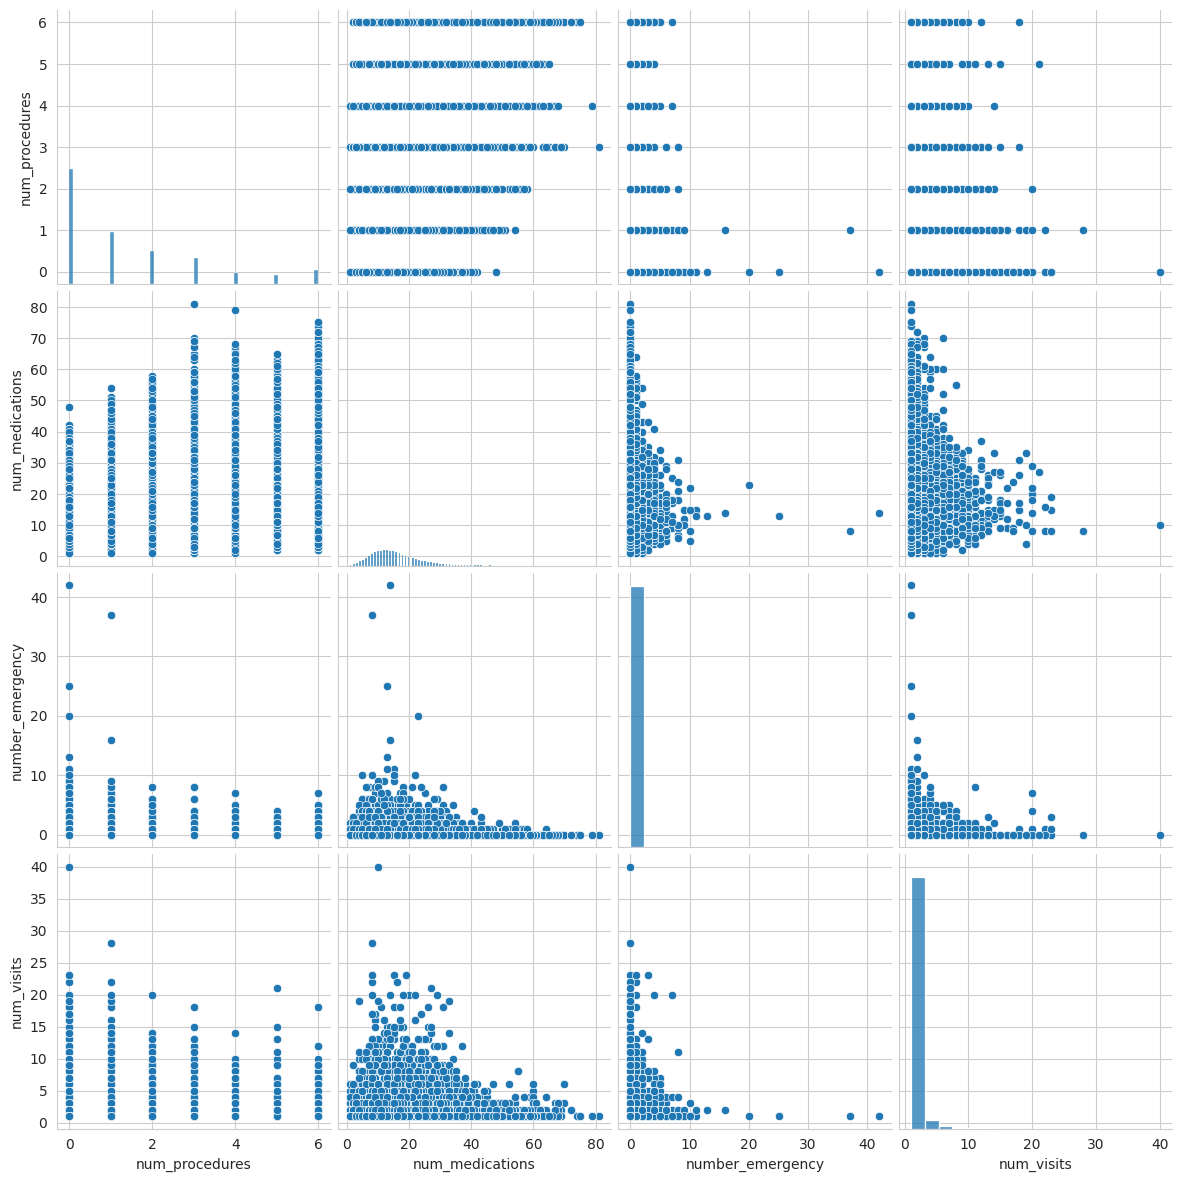

In [82]:
import seaborn as sns
sns.set_style("whitegrid");
sns.pairplot(data[['num_procedures', 'num_medications', 'number_emergency', 'num_visits']], height=3);
plt.show()

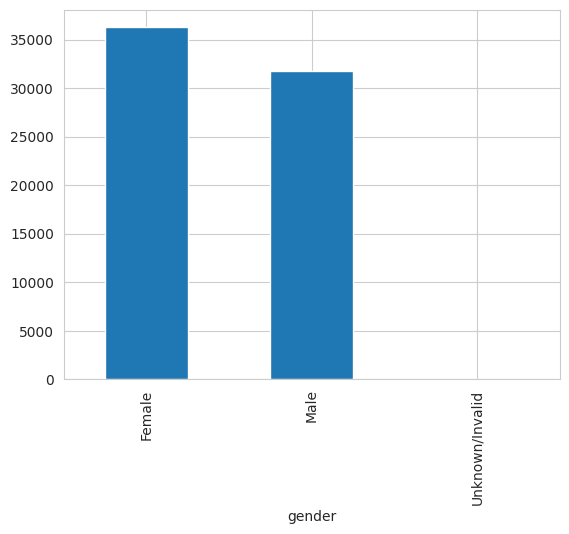

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns= ["gender"])

df["gender"].value_counts().plot.bar()

plt.show()

In [84]:
df["gender"].value_counts()

,count
gender,
Female,36262
Male,31792
Unknown/Invalid,1


In [85]:
# data=data[(data.gender != 'Unknown/Invalid')]
data.loc[(data.gender == 'Unknown/Invalid'),'gender']='Female'

In [86]:
data.shape

(68055, 46)

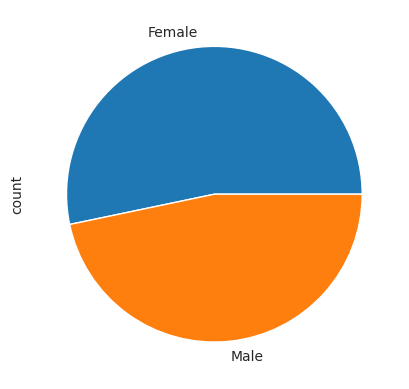

In [87]:
data["gender"].value_counts().plot.pie()
plt.gca().set_aspect("equal")

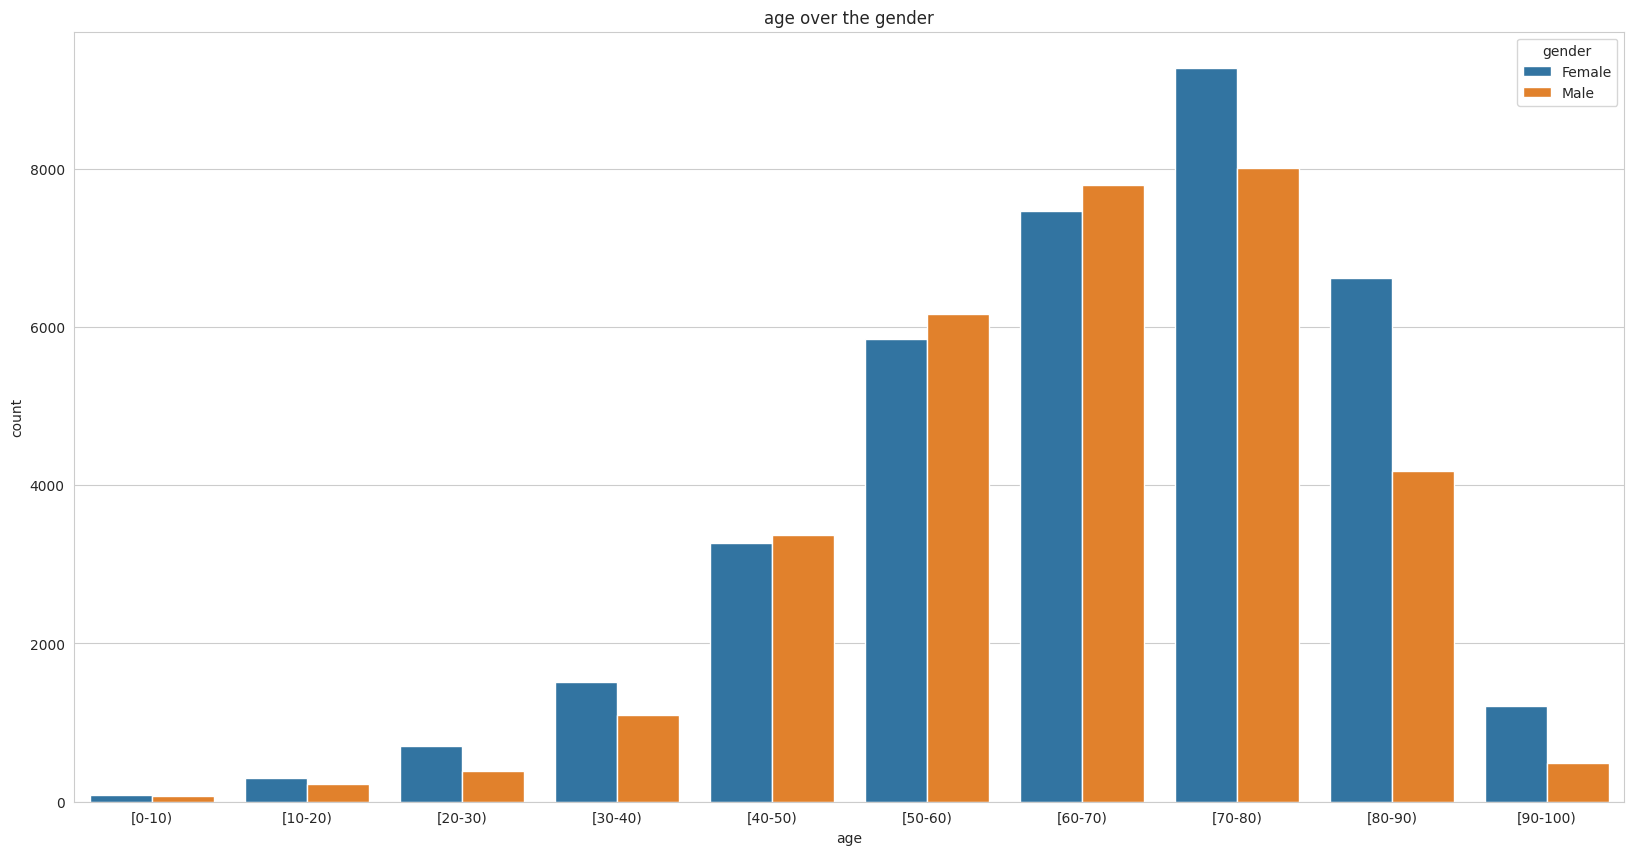

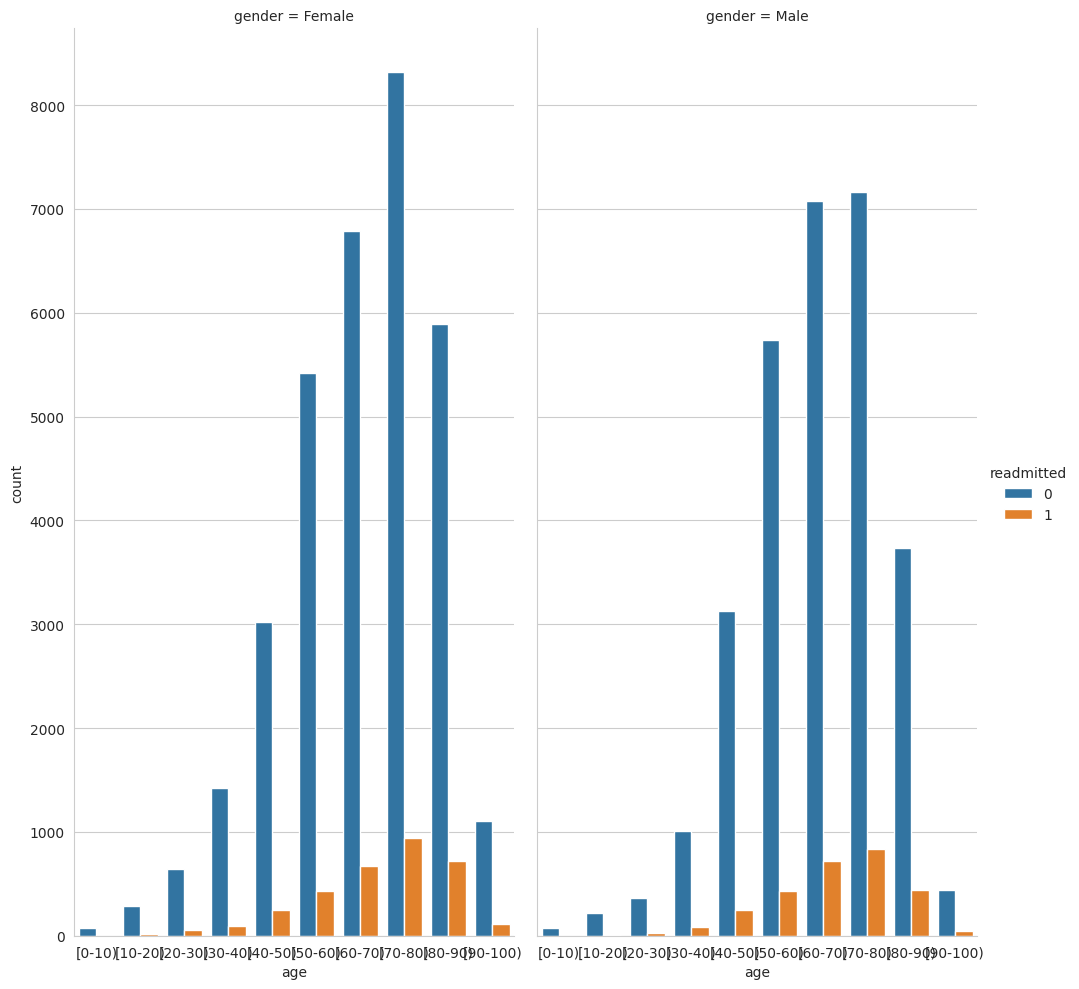

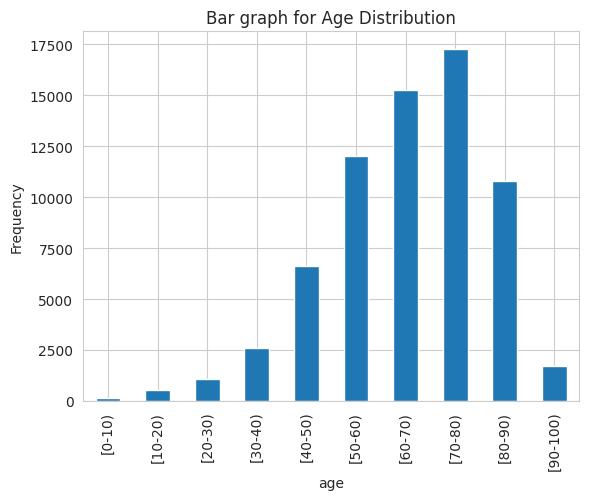

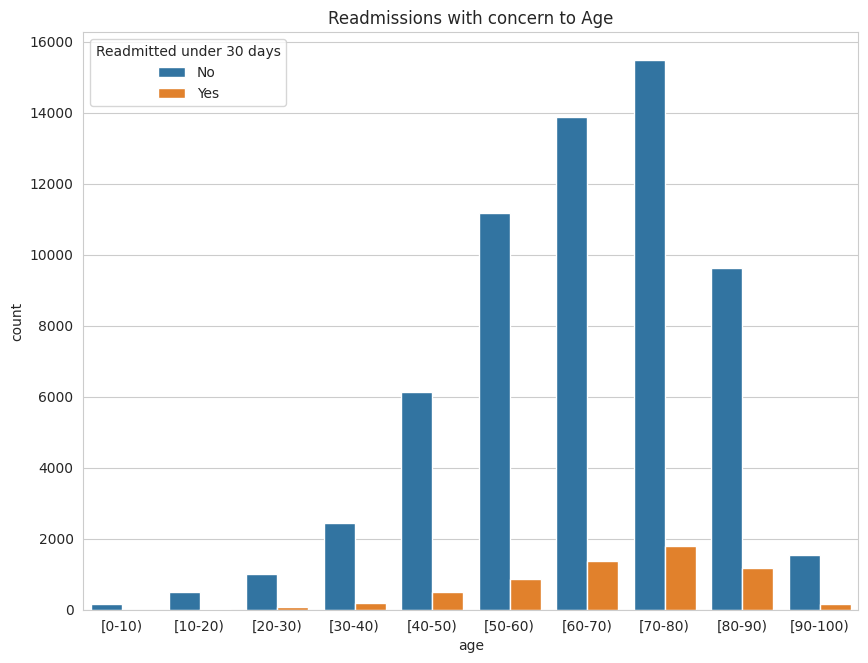

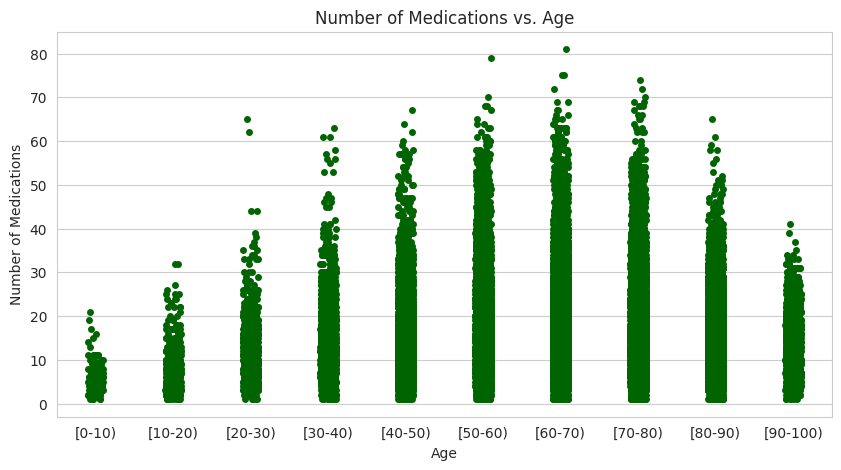

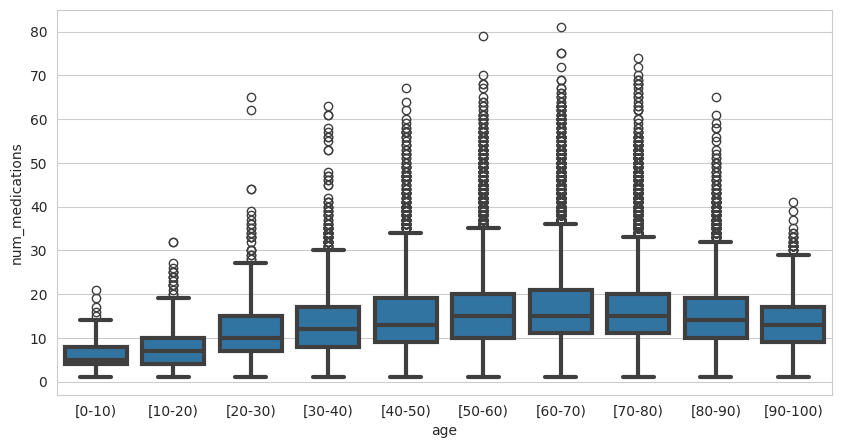

In [89]:
plt.close()
unique_age =data['age'].unique()
unique_age.sort()
sorted_age = np.array(unique_age).tolist()

plot=sns.countplot(x = 'age', hue = 'gender', data = data, order =sorted_age)
plot.figure.set_size_inches(20,10)
plot.legend(title = 'gender')
plot.axes.set_title('age over the gender')
plt.show()



plt.close()
unique_age =data['age'].unique()
unique_age.sort()
sorted_age = np.array(unique_age).tolist()

plot= sns.catplot(x="age", hue="readmitted", col="gender",
                data=data, kind="count",order=sorted_age,
                height=10, aspect=.5);

plt.show()




data.shape

data.groupby(['age']).size()



age_cat = data.groupby(['age']).size()
age_cat.plot(kind = 'bar')
plt.ylabel('Frequency')
plt.title('Bar graph for Age Distribution')
plt.show()


unique_age =data['age'].unique()
unique_age.sort()
sorted_age = np.array(unique_age).tolist()

# we will try to show the age and the readmissions in a single plot
plot = sns.countplot(x = 'age', hue = 'readmitted', data = data, order =sorted_age)

plot.figure.set_size_inches(10, 7.5)
plot.legend(title = 'Readmitted under 30 days', labels = ('No', 'Yes'))
plot.axes.set_title('Readmissions with concern to Age')
plt.show()

sorted_age = data.sort_values(by = 'age')
med_age = sns.stripplot(x = "age", y = "num_medications", data = sorted_age, color = 'darkgreen')
med_age.figure.set_size_inches(10, 5)
med_age.set_xlabel('Age')
med_age.set_ylabel('Number of Medications')
med_age.axes.set_title('Number of Medications vs. Age')
plt.show()


plt.figure(figsize=(10,5))
sns.boxplot(x='age',y='num_medications', data=sorted_age,linewidth=3,orient="v")
plt.show()

In [90]:
# dictionary
HbA1C_percentages = {'none': 5033/(49718+5033), '>7': 237/(2535+237), '>8': 488/(5215+488), 'normal': 316/(3302+316)}
print(HbA1C_percentages)

{'none': 0.09192526163905682, '>7': 0.0854978354978355, '>8': 0.08556899877257584, 'normal': 0.08734107241569929}


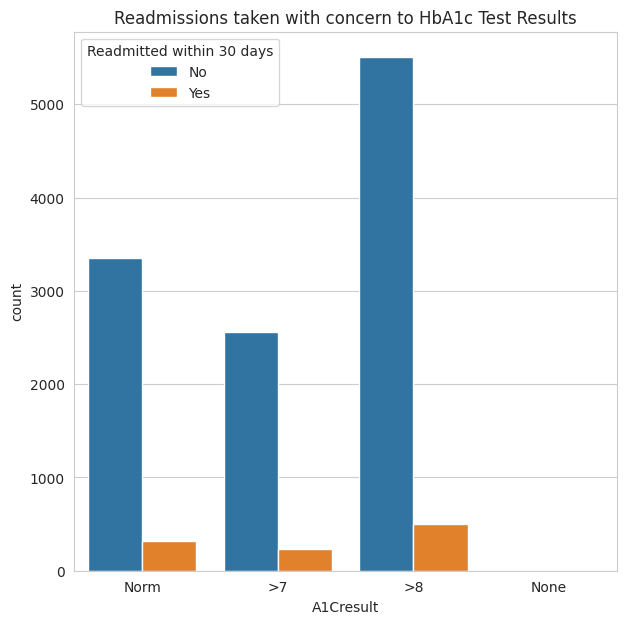

In [91]:
HbA1C = sns.countplot(x = 'A1Cresult', hue = 'readmitted', data = data, order = ['Norm', '>7', '>8', 'None'])
HbA1C.figure.set_size_inches(7, 7)
HbA1C.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
HbA1C.axes.set_title('Readmissions taken with concern to HbA1c Test Results')
plt.show()

In [92]:
#create new, binary column to show whether HbA1c test performed or not
data['HbA1c'] = np.where(data['A1Cresult'] == 'None', 0, 1)

#cross tab of HbA1c test and readmission w/in 30 days
HbA1c_ct = pd.crosstab(index = data['HbA1c'], columns = data['readmitted'], margins = True)
HbA1c_ct

readmitted,0,1,All
HbA1c,,,
1,61919,6136,68055
All,61919,6136,68055


In [93]:
test =1078/12845
not_tested=5199/57128
all_people=6277/69973
print(test,not_tested,all_people)

data.shape

0.08392370572207085 0.09100616160201652 0.08970602946850928


(68055, 47)

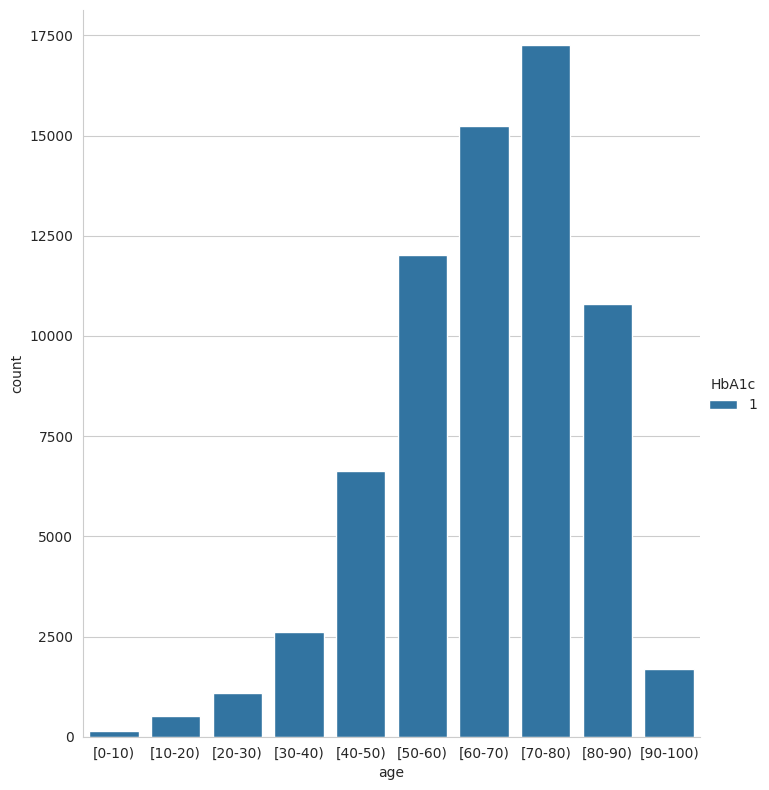

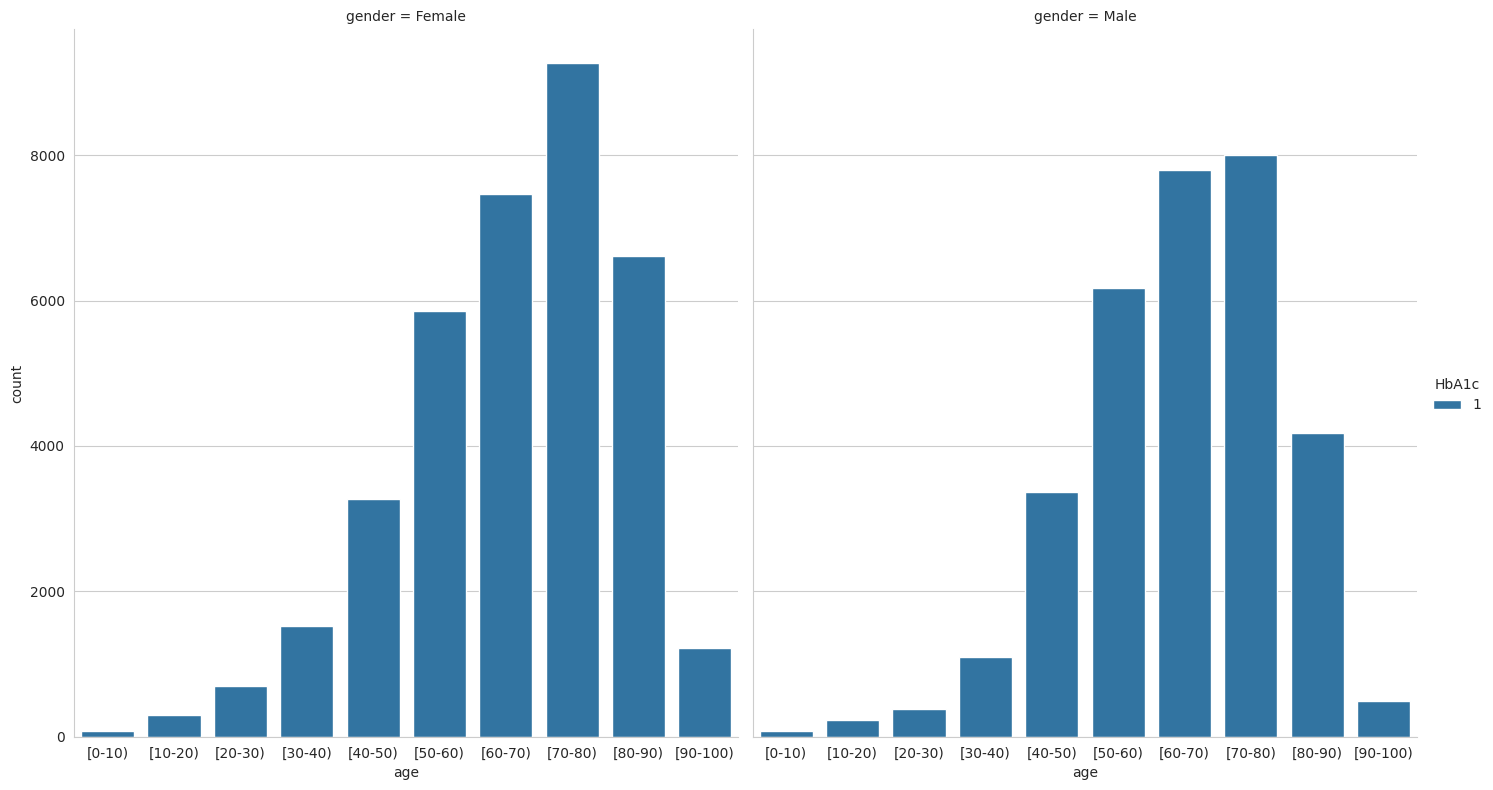

In [94]:
def chisq_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    return(scs.chi2_contingency(ctsum))

    #run test
chisq_cols(data, 'HbA1c', 'readmitted')



plt.close()
unique_age =data['age'].unique()
unique_age.sort()
sorted_age = np.array(unique_age).tolist()

plot= sns.catplot(x="age", hue="HbA1c",
                data=data, kind="count",order=sorted_age,
                height=8, aspect=.9);

plt.show()




plt.close()
unique_age =data['age'].unique()
unique_age.sort()
sorted_age = np.array(unique_age).tolist()

plot= sns.catplot(x="age", hue="HbA1c",col="gender",
                data=data, kind="count",order=sorted_age,
                height=8, aspect=.9);

plt.show()

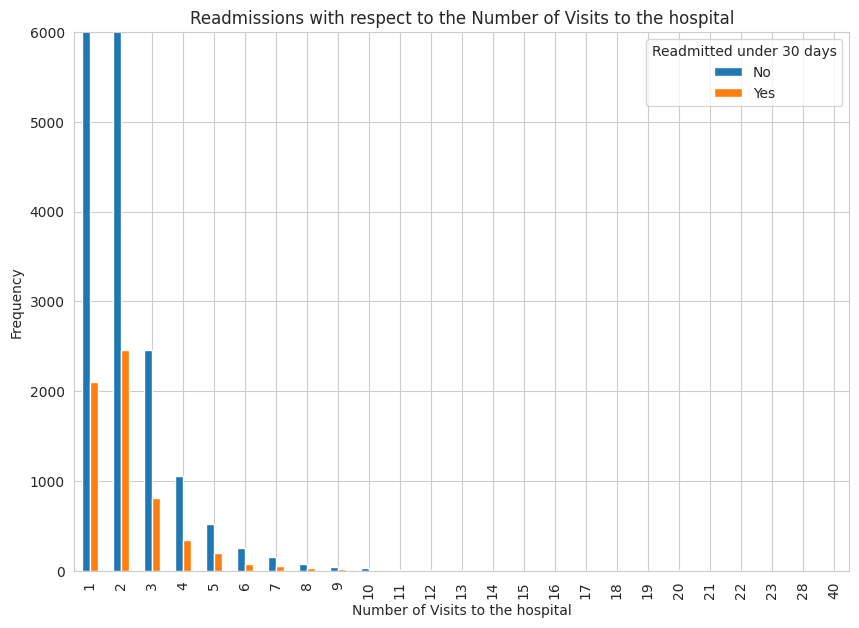

In [95]:
# creating a crosstab with rows as the num_visits and the column names as the readmitted
visits_ct = pd.crosstab(index = data['num_visits'], columns = data['readmitted'])
visits_df = pd.DataFrame(visits_ct.reset_index())

Vlevels = visits_df.num_visits.tolist()
Vmapping = {level: i for i, level in enumerate(Vlevels)}
Vkey = visits_df['num_visits'].map(Vmapping)
Vsorting = visits_df.iloc[Vkey.argsort()]
v = Vsorting.plot(kind = 'bar', x = 'num_visits')

v.figure.set_size_inches(10, 7)
v.set_ylim([0, 6000])
v.set_xlabel('Number of Visits to the hospital')
v.set_ylabel('Frequency')
v.legend(title = 'Readmitted under 30 days', labels = ('No', 'Yes'))
v.axes.set_title('Readmissions with respect to the Number of Visits to the hospital')
plt.show()

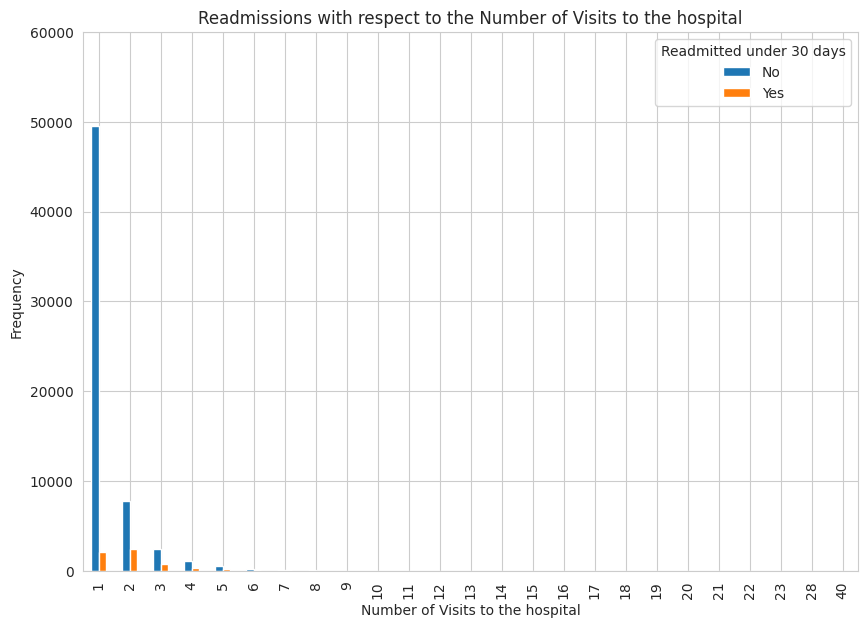

In [96]:
v = Vsorting.plot(kind = 'bar', x = 'num_visits')
v.figure.set_size_inches(10, 7)
v.set_ylim([0, 60000])
v.set_xlabel('Number of Visits to the hospital')
v.set_ylabel('Frequency')
v.legend(title = 'Readmitted under 30 days', labels = ('No', 'Yes'))
v.axes.set_title('Readmissions with respect to the Number of Visits to the hospital')
plt.show()

In [98]:
# Binning the  lab procedure feature using a function
def binary_lab_procedures(col):
    if (col >= 1) & (col <= 10):
        return '[1-10]'
    if (col >= 11) & (col <= 20):
        return '[11-20]'
    if (col >= 21) & (col <= 30):
        return '[21-30]'
    if (col >= 31) & (col <= 40):
        return '[31-40]'
    if (col >= 41) & (col <= 50):
        return '[41-50]'
    if (col >= 51) & (col <= 60):
        return '[51-60]'
    if (col >= 61) & (col <= 70):
        return '[61-70]'
    if (col >= 71) & (col <= 80):
        return '[71-80]'
    if (col >= 81) & (col <= 90):
        return '[81-90]'
    if (col >= 91) & (col <= 100):
        return '[91-100]'
    if (col >= 101) & (col <= 110):
        return '[101-110]'
    if (col >= 111) & (col <= 120):
        return '[111-120]'
    else:
        return '[121-132]'

In [99]:
data['num_lab_procedure_ranges'] = data['num_lab_procedures'].apply(lambda x: binary_lab_procedures(x))
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,no_of_days_admitted,num_lab_procedures,num_procedures,num_medications,...,metformin_pioglitazone,change,diabetesMed,readmitted,num_visits,first_diag,second_diag,third_diag,HbA1c,num_lab_procedure_ranges
4267,Caucasian,Female,[50-60),2,1,1,8,77,6,33,...,No,Ch,Yes,1,2,circulatory,injury,digestive,1,[71-80]
5827,Caucasian,Female,[50-60),3,1,1,2,49,1,11,...,No,No,No,0,1,musculoskeletal,other,diabetes,1,[41-50]
67608,Caucasian,Female,[80-90),1,3,7,4,68,2,23,...,No,No,Yes,0,1,injury,respiratory,other,1,[61-70]
17494,Caucasian,Female,[80-90),1,1,7,3,46,0,20,...,No,Ch,Yes,0,1,neoplasms,circulatory,circulatory,1,[41-50]
2270,AfricanAmerican,Female,[30-40),1,1,7,5,49,0,5,...,No,No,Yes,0,1,genitourinary,neoplasms,diabetes,1,[41-50]


In [101]:
# remove our num_lab_procedures feature
data=data.drop(['num_lab_procedures'], axis = 1)

# cange our categorical variables from numeric to object
columns = data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']]
data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] = columns.astype(object)


data.columns

print(data.dtypes.unique())

from sklearn.preprocessing import LabelEncoder
data_example=data.apply(LabelEncoder().fit_transform)
data_example.head()

data_example.shape


# data_encoded = pd.get_dummies(data, columns = None, drop_first = True)
pd.options.display.max_columns = 999

data_encoded=data_example
data_encoded.head()

final_dataset_preprocessed = pd.DataFrame(data_encoded)
final_dataset_preprocessed.to_csv('final_dataset_preprocessed.csv', index=True)

final_dataset_preprocessed.to_csv('final_dataset_preprocessed_without_index.csv', index=False)



[dtype('O') dtype('int64')]


### MODELING

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
features = list(data_encoded)
features = [x for x in features if x not in ('Unnamed: 0', 'readmitted')]

X = data_encoded[features].values
y = data.readmitted.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .2, random_state = 7, stratify = y)
X_train1,X_test1,ytrain1,ytest1=train_test_split(X_train,Y_train,test_size=.5)

In [105]:
# generating samples
def generating_sample(X_train1, ytrain1):
    Selecting_row = np.sort(np.random.choice(X_train1.shape[0], 8166, replace=True))  # Use shape[0]
    Replacing_row = np.sort(np.random.choice(Selecting_row, 5444, replace=True))
    # Use shape[1] to get the correct number of columns
    Selecting_column = np.sort(np.random.choice(X_train1.shape[1], int(X_train1.shape[1] * 0.64), replace=True))
    sample_data = X_train1[Selecting_row[:, None], Selecting_column]
    target_of_sample_data = ytrain1[Selecting_row[:, None]]
    replicated_data = X_train1[Replacing_row[:, None], Selecting_column]
    target_of_replicated_data = ytrain1[Replacing_row[:, None]]
    final_sample_data = np.vstack((sample_data, replicated_data))
    final_target_data = np.vstack((target_of_sample_data.reshape(-1, 1), target_of_replicated_data.reshape(-1, 1)))
    return final_sample_data, final_target_data, Selecting_row, Selecting_column

# collecting the final data into lists that we got after sampling from our train data
list_input_data=[]
list_output_data = []
list_selected_rows =[]
list_selected_columns = []
for i in range(0,30):
    a,b,c,d = generating_sample(X_train1,ytrain1)
    list_input_data.append(a)   # this is the inpput data that we got from the train set
    list_output_data.append(b)  # this is the labelled target data that we got from the train data
    list_selected_rows.append(c)
    list_selected_columns.append(d)

# Implementing grid search to fine tune using the best  Hyperparameters
C_grid = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]}
weights = {0: .1, 1: .9} # giving weights
clf_grid = GridSearchCV(LogisticRegression(penalty='l2', class_weight = weights), C_grid, cv = 5, scoring = 'accuracy')
# fitting the model on the train data we received as lists
clf_grid.fit(list_input_data[i],list_output_data[i])

GridSearchCV(cv=5, estimator=LogisticRegression(class_weight={0: 0.1, 1: 0.9}),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy')

In [106]:
# compile base models into a single list
all_selected_models = []
for i in range(30):
    model = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2',class_weight = weights)
    model.fit(list_input_data[i],list_output_data[i])
    all_selected_models.append(model)

# test all our base models on the data that we got in the second train_test split that we kept for trainig the base models
list_input_data=[]
list_output_data = []
list_selected_rows =[]
list_selected_columns = []
for i in range(0,30):
    a,b,c,d = generating_sample(X_test1,ytest1)
    list_input_data.append(a)
    list_output_data.append(b)
    list_selected_rows.append(c)
    list_selected_columns.append(d)

# test on our meta classifier
D_meta = [ ]
for i in range(30):
    y_pred = all_selected_models[i].predict(list_input_data[i])
    D_meta.append(y_pred)

#  data not in our required shape so we are converting it as required
def convert(list_output_data):
    final = []
    for i in list_output_data:
        m = []
        for j in i:
            for k in j:
                m.append(k)
        final.append(m)
    return final
list_output_data_final = convert(list_output_data)

In [107]:
# fit the meta model on both the outputs that we received from our meta_classifier earlier on train data and the data that we converted earlier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import recall_score

clf_rf = ExtraTreesClassifier()
meta_model=clf_rf.fit(D_meta, list_output_data_final)

In [109]:
# sample data to test shape for match

def generating_sample(X_train1, ytrain1):
    Selecting_row = np.sort(np.random.choice(X_train1.shape[0], 8166, replace=True))
    Replacing_row = np.sort(np.random.choice(Selecting_row, 5444, replace=True))

    # Change here: Limit Selecting_column to the actual number of columns in X_train1
    Selecting_column = np.sort(np.random.choice(X_train1.shape[1], int(X_train1.shape[1] * 0.64), replace=True))

    sample_data = X_train1[Selecting_row[:, None], Selecting_column]
    target_of_sample_data = ytrain1[Selecting_row[:, None]]
    replicated_data = X_train1[Replacing_row[:, None], Selecting_column]
    target_of_replicated_data = ytrain1[Replacing_row[:, None]]
    final_sample_data = np.vstack((sample_data, replicated_data))
    final_target_data = np.vstack((target_of_sample_data.reshape(-1, 1), target_of_replicated_data.reshape(-1, 1)))
    return final_sample_data, final_target_data, Selecting_row, Selecting_column


list_input_data=[]
list_output_data = []
list_selected_rows =[]
list_selected_columns = []
for i in range(0,30):
    a,b,c,d = generating_sample(X_test,Y_test)
    list_input_data.append(a)
    list_output_data.append(b)
    list_selected_rows.append(c)
    list_selected_columns.append(d)

D_meta_2 = [ ]
for i in range(30):
    y_pred = all_selected_models[i].predict(list_input_data[i])
    D_meta_2.append(y_pred)

In [110]:
# test unseenb dATA - from 20% left from first split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import recall_score

clf_rf = ExtraTreesClassifier()
meta_model=clf_rf.fit(D_meta, list_output_data_final)

pred_model=meta_model.predict(D_meta_2)
def convert(list_output_data):
    final = []
    for i in list_output_data:
        m = []
        for j in i:
            for k in j:
                m.append(k)
        final.append(m)
    return final

list_output_data_final_test = convert(list_output_data)

In [111]:
from sklearn.metrics import f1_score
accuracy_score(np.argmin(pred_model, axis=1),np.argmin(list_output_data_final_test, axis=1))

0.7

In [113]:
f1_score(np.argmin(pred_model, axis=1),np.argmin(list_output_data_final_test, axis=1), average='macro')


0.20588235294117646

In [114]:
f1_score(np.argmin(pred_model, axis=1),np.argmin(list_output_data_final_test, axis=1), average='weighted')


0.8235294117647058

In [115]:
f1_score(np.argmin(pred_model, axis=1),np.argmin(list_output_data_final_test, axis=1), average='micro')


0.7

### Ensemble with Classifier (stacking)


In [116]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

X=data_encoded.drop('readmitted',axis=1)
y=data_encoded.readmitted

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .2, random_state = 7, stratify = y)

In [117]:
X_train.shape

(54444, 46)

In [118]:
X_test.shape

(13611, 46)

In [119]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  ExtraTreesClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

clf1 = KNeighborsClassifier(n_neighbors=5)   # First claassifier is KNN
clf2 = RandomForestClassifier(random_state=5)  # Second is the Random Forest
clf3 = ExtraTreesClassifier()                 # Third is the ExtraTreesClassifier
cl4= GaussianNB()
cl5= LogisticRegression(penalty='l2')
mlc=RandomForestClassifier(random_state=7)
sclf = StackingClassifier(classifiers=[clf1, clf2,clf3,cl4,cl5],
                          meta_classifier=mlc)                 # using the stacking classifier from mlxtend

print('3-fold cross validation:\n')                              # using a 3 fold cross-validaton

for clf, label in zip([clf1, clf2,clf3,cl4,cl5, sclf],
                      ['KNN',
                       'Random Forest',
                       'ExtraTreesClassifier',
                       'GaussianNB',
                       'Logistic Regression',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train,Y_train,
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f [%s]"
          % (scores.mean(), label))

3-fold cross validation:

Accuracy: 0.90 [KNN]
Accuracy: 0.91 [Random Forest]
Accuracy: 0.91 [ExtraTreesClassifier]
Accuracy: 0.10 [GaussianNB]
Accuracy: 0.91 [Logistic Regression]
Accuracy: 0.91 [StackingClassifier]


In [120]:
# Fitting the data on the stacking classifier
sclf.fit(X_train,Y_train)

StackingClassifier(classifiers=[KNeighborsClassifier(),
                                RandomForestClassifier(random_state=5),
                                ExtraTreesClassifier(), GaussianNB(),
                                LogisticRegression()],
                   meta_classifier=RandomForestClassifier(random_state=7))

In [121]:
import pickle
file=open('stacking_classifier_model_final_last.pkl','wb')
pickle.dump(sclf,file)

In [122]:
X_train.shape

(54444, 46)

In [123]:
X_test.shape

(13611, 46)

In [124]:
# X_test=pd.DataFrame(X_test)
# X_test.reset_index(inplace=True)
y_pred=sclf.predict(X_test.iloc[0:5])
y_pred

array([0, 0, 0, 0, 0])

In [125]:
y_pred=sclf.predict(X_test)

In [126]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_pred[0:13611], average='macro')

0.47880482925793705

In [127]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_pred[0:13611], average='micro')

0.9097788553375946

In [128]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_pred[0:13611], average='weighted')

0.867297776577218

### Logistic Regression

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
features = list(data_encoded)
features = [x for x in features if x not in ('Unnamed: 0', 'readmitted')]

In [130]:
X = data_encoded[features].values
y = data.readmitted.values
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = .2, random_state = 7, stratify = y)

In [131]:
C_grid = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]}
weights = {0: .1, 1: .9}
clf_grid = GridSearchCV(LogisticRegression(penalty='l2', class_weight = weights), C_grid, cv = 5, scoring = 'accuracy')
# fitting the model
clf_grid.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, estimator=LogisticRegression(class_weight={0: 0.1, 1: 0.9}),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy')

In [132]:
# best c-value and accuracy score
print(clf_grid.best_params_, clf_grid.best_score_)

{'C': 0.01} 0.7898942447699986


In [134]:
# classifier cv grid
clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2',class_weight = weights)
clf_grid_best.fit(Xtrain, Ytrain)
# predicting on the train data
x_pred_train = clf_grid_best.predict(Xtrain)
# getting the accuracy score
accuracy_score(x_pred_train, Ytrain)

0.7903533906399236

In [135]:
# Accuracy on test data: clf_grid_best.fit(Xtest, Ytest)
# predicting on test data
x_pred_test = clf_grid_best.predict(Xtest)
# getting the accuracy score
accuracy_score(x_pred_test, Ytest)

0.7938432150466534

In [136]:
report_train = classification_report(Ytrain, x_pred_train)
print(report_train)

              precision    recall  f1-score   support

           0       0.95      0.81      0.88     49535
           1       0.23      0.57      0.33      4909

    accuracy                           0.79     54444
   macro avg       0.59      0.69      0.60     54444
weighted avg       0.89      0.79      0.83     54444



In [137]:
report_test = classification_report(Ytest, x_pred_test)
print(report_test)

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     12384
           1       0.23      0.56      0.33      1227

    accuracy                           0.79     13611
   macro avg       0.59      0.69      0.60     13611
weighted avg       0.88      0.79      0.83     13611



In [138]:
#same as earlier here even we are using the l2 regularization and 5-fold cross-validation
C_grid = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]}
clf_ROC = GridSearchCV(LogisticRegression(penalty='l2', class_weight = weights),
                            C_grid, cv = 5, scoring = 'roc_auc')
clf_ROC.fit(Xtrain, Ytrain)
print(clf_ROC.best_params_, clf_ROC.best_score_)

{'C': 0.1} 0.7750255504205956


In [139]:
print(clf_ROC.best_params_, clf_ROC.best_score_)


{'C': 0.1} 0.7750255504205956


In [143]:
# best value C training and test data
import warnings
warnings.filterwarnings("ignore")
clf_ROC_best = LogisticRegression(penalty='l2', class_weight = weights,
                                       C = clf_ROC.best_params_['C'])
clf_ROC_best.fit(Xtrain, Ytrain)

probability_train = clf_ROC_best.predict_proba(Xtrain)
predicted_train = probability_train[:,1]
roc_auc_score(Ytrain, predicted_train)




0.7777947953243634

In [142]:
# on test data
clf_ROC_best.fit(Xtest, Ytest)
probability_test = clf_ROC_best.predict_proba(Xtest)
predicted_test = probability_test[:,1]
roc_auc_score(Ytest, predicted_test)

0.7862166446596707

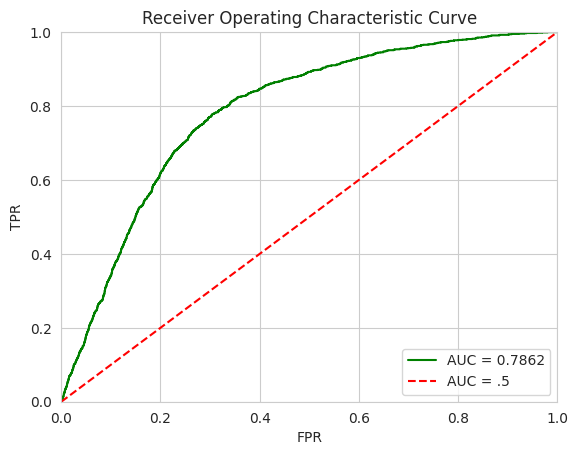

In [144]:
# FPR fale positive   tpr = true positive

# plot ROC curve from test data
fpr, tpr, threshold = roc_curve(Ytest, predicted_test)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'green', label = 'AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label = 'AUC = .5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [148]:
# Confusion MAtrix for train
actual_train = pd.Series(Ytrain, name = 'Actual')
predict_train = pd.Series(x_pred_train, name = 'Predicted')
train_ct = pd.crosstab(actual_train, predict_train, margins = True)
print(train_ct)


# printing the percentage values
TN_train = train_ct.iloc[0,0] / train_ct.iloc[0,2]
TP_train = train_ct.iloc[1,1] / train_ct.iloc[1,2]
print('Training accuracy for not readmitted: {}'.format('%0.3f' % TN_train))
print('Training accuracy for being readmitted : {}'.format('%0.3f' % TP_train))

Predicted      0      1    All
Actual                        
0          40218   9317  49535
1           2097   2812   4909
All        42315  12129  54444
Training accuracy for not readmitted: 0.812
Training accuracy for being readmitted : 0.573


In [149]:
# confusion matrix for test data
actual_test = pd.Series(Ytest, name = 'Actual')
predict_test = pd.Series(x_pred_test, name = 'Predicted')
test_ct = pd.crosstab(actual_test, predict_test, margins = True)
print(test_ct)

TN_test = test_ct.iloc[0,0] / test_ct.iloc[0,2]
TP_test = test_ct.iloc[1,1] / test_ct.iloc[1,2]
print('Test accuracy for not readmitted: {}'.format('%0.3f' % TN_test))
print('Test accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_test))

Predicted      0     1    All
Actual                       
0          10117  2267  12384
1            539   688   1227
All        10656  2955  13611
Test accuracy for not readmitted: 0.817
Test accuracy for readmitted (Recall): 0.561


### Undersampling


In [152]:
# independent variables
features = list(data_encoded)
features = [x for x in features if x not in ('Unnamed: 0', 'readmitted')]



In [154]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

X = data_encoded[features].values
Y = data_encoded.readmitted.values
#undersampling
rus = RandomUnderSampler(random_state = 31)
X_res, Y_res = rus.fit_resample(X, Y) # Changed fit_sample to fit_resample
Counter(Y_res)

Counter({0: 6136, 1: 6136})

### train Test Split

In [155]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_res, Y_res, test_size = .2,random_state = 31, stratify = Y_res)


### Grid Search CV using L2 reg w/ 5-fold cv

In [156]:
C_grid = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]}
clf_grid = GridSearchCV(LogisticRegression(penalty='l2'), C_grid, cv = 5, scoring = 'accuracy')
clf_grid.fit(Xtrain, Ytrain)

print(clf_grid.best_params_, clf_grid.best_score_)

{'C': 1000} 0.6996037695326887


In [158]:
# Accuracy on training data:
clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2')
clf_grid_best.fit(Xtrain, Ytrain)

x_pred_train = clf_grid_best.predict(Xtrain)
accuracy_score(x_pred_train, Ytrain)


0.7034735662626057

In [160]:
# Accuracy on Test Data
clf_grid_best.fit(Xtest, Ytest)

x_pred_test = clf_grid_best.predict(Xtest)
accuracy_score(x_pred_test, Ytest)

0.7120162932790224

### LR model w/ undersampliung : Confusion Matrix

In [162]:
actual = pd.Series(Ytest, name = 'Actual')
predicted_rus = pd.Series(clf_grid_best.predict(Xtest), name = 'Predicted')
ct_rus = pd.crosstab(actual, predicted_rus, margins = True)
print(ct_rus)

# W/ %'s
TN_rus = ct_rus.iloc[0,0] / ct_rus.iloc[0,2]
TP_rus = ct_rus.iloc[1,1] / ct_rus.iloc[1,2]
print('Logistic Regression accuracy for not readmitted: {}'.format('%0.3f' % TN_rus))
print('Logistic Regression accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_rus))

Predicted     0     1   All
Actual                     
0           951   277  1228
1           430   797  1227
All        1381  1074  2455
Logistic Regression accuracy for not readmitted: 0.774
Logistic Regression accuracy for readmitted (Recall): 0.650


### SMOTE for oversampling


In [166]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = data_encoded[features].values
Y = data_encoded.readmitted.values

sm = SMOTE(random_state = 31)
# Use fit_resample instead of fit_sample
X_resamp, Y_resamp = sm.fit_resample(X, Y)
Counter(Y_resamp)

Counter({1: 61919, 0: 61919})

In [167]:
# Train Test Split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resamp, Y_resamp, test_size = .2,random_state = 31, stratify = Y_resamp)


#  After split use the GridSearchCV with L2 regularization and 5-fold cross-validation along with the model being the Logistic Regression
C_grid = {'C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000]}
clf_grid = GridSearchCV(LogisticRegression(penalty='l2'), C_grid, cv = 5, scoring = 'accuracy')
clf_grid.fit(Xtrain, Ytrain)
print(clf_grid.best_params_, clf_grid.best_score_)

{'C': 10} 0.7463813465226609


In [168]:
# Accuracy on training data
clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2')
clf_grid_best.fit(Xtrain, Ytrain)
x_pred_train = clf_grid_best.predict(Xtrain)
accuracy_score(x_pred_train, Ytrain)

# Acuracy on test data
clf_grid_best.fit(Xtest, Ytest)
x_pred_test = clf_grid_best.predict(Xtest)
accuracy_score(x_pred_test, Ytest)

0.7511708656330749

In [170]:
# F1 Score weighjted
from sklearn.metrics import f1_score
f1_score(Ytest[0:13611], y_pred, average='weighted')



0.33456521325810246

In [171]:
# F1 Score macro
from sklearn.metrics import f1_score
f1_score(Ytest[0:13611], y_pred, average='macro')



0.3343941440937978

In [172]:
# F1 Score micro
from sklearn.metrics import f1_score
f1_score(Ytest[0:13611], y_pred, average='micro')

0.5006244948938359

In [181]:
# Confusion Matrix on Train Data
actual_tr = pd.Series(Ytrain, name = 'Actual')
predicted_sm_tr = pd.Series(clf_grid_best.predict(Xtrain), name = 'Predicted')
ct_sm_tr = pd.crosstab(actual_tr, predicted_sm_tr, margins = True)
print(ct_sm_tr)


TN_sm_tr = ct_sm_tr.iloc[0,0] / ct_sm_tr.iloc[0,2]
TP_sm_tr = ct_sm_tr.iloc[1,1] / ct_sm_tr.iloc[1,2]
Prec_sm_tr = ct_sm_tr.iloc[1,1] / ct_sm_tr.iloc[2,1]
print('Training Accuracy for not readmitted: {}'.format('%0.3f' % TN_sm_tr))
print('Training Accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_sm_tr))
print('Training Correct Positive Predictions (Precision): {}'.format('%0.3f' % Prec_sm_tr))

Predicted      0      1    All
Actual                        
0          37326  12209  49535
1          12983  36552  49535
All        50309  48761  99070
Training Accuracy for not readmitted: 0.754
Training Accuracy for readmitted (Recall): 0.738
Training Correct Positive Predictions (Precision): 0.750


In [182]:
# Confusion matrix on test data
# confusion matrix with SMOTE oversampling (test data)
actual = pd.Series(Ytest, name = 'Actual')
predicted_sm = pd.Series(clf_grid_best.predict(Xtest), name = 'Predicted')
ct_sm = pd.crosstab(actual, predicted_sm, margins = True)
print(ct_sm)


TN_sm = ct_sm.iloc[0,0] / ct_sm.iloc[0,2]
TP_sm = ct_sm.iloc[1,1] / ct_sm.iloc[1,2]
Prec_sm = ct_sm.iloc[1,1] / ct_sm.iloc[2,1]
print('Accuracy for not readmitted: {}'.format('%0.3f' % TN_sm))
print('Accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_sm))
print('Correct Positive Predictions (Precision): {}'.format('%0.3f' % Prec_sm))

Predicted      0      1    All
Actual                        
0           9381   3003  12384
1           3160   9224  12384
All        12541  12227  24768
Accuracy for not readmitted: 0.758
Accuracy for readmitted (Recall): 0.745
Correct Positive Predictions (Precision): 0.754


In [183]:
logistic_coefs = clf_grid_best.coef_[0]
logistic_coef_df = pd.DataFrame({'feature': features, 'coefficient': logistic_coefs})
logistic_df = logistic_coef_df.sort_values('coefficient', ascending = False)
logistic_df.head(10)

,feature,coefficient
27,miglitol,2.181177
18,chlorpropamide,2.056540
17,nateglinide,1.441789
33,glyburide_metformin,1.289757
16,repaglinide,0.913160
40,num_visits,0.433143
11,number_inpatient,0.183138
12,number_diagnoses,0.040317
4,discharge_disposition_id,0.028854
8,num_medications,0.018405


In [188]:
# repeat undewrsampling
# getting the independent variables
features = list(data_encoded)
features = [x for x in features if x not in ('Unnamed: 0', 'readmitted')]

# undersampling from majority class:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

X = data_encoded[features].values
Y = data_encoded.readmitted.values

In [190]:
# Undersampling Method X #

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from collections import Counter
import pandas as pd

# Number of trials
number_of_repeations = 10

# Declare empty lists for true-positive and true-negative rates
TNR = []
TPR = []

# For loop for multiple trials
for trial in range(number_of_repeations):
    # Random undersampling
    rus = RandomUnderSampler(random_state=31 * trial)  # Randomized seed
    X_res, Y_res = rus.fit_resample(X, Y)  # Corrected method
    print(Counter(Y_res))  # Print results for each trial

    # Train/test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(
        X_res, Y_res, test_size=0.2, stratify=Y_res, random_state=2 * trial
    )

    # Hyperparameter tuning with grid search
    C_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    clf_grid = GridSearchCV(
        LogisticRegression(penalty='l2'), C_grid, cv=5, scoring='accuracy'
    )
    clf_grid.fit(Xtrain, Ytrain)
    print(clf_grid.best_params_, clf_grid.best_score_)

    # Train logistic regression with the best parameter
    clf_grid_best = LogisticRegression(C=clf_grid.best_params_['C'], penalty='l2')
    clf_grid_best.fit(Xtrain, Ytrain)

    # Evaluate on training data
    x_pred_train = clf_grid_best.predict(Xtrain)
    print("Training Accuracy:", accuracy_score(Ytrain, x_pred_train))

    # Evaluate on test data
    x_pred_test = clf_grid_best.predict(Xtest)
    print("Test Accuracy:", accuracy_score(Ytest, x_pred_test))

    # Confusion matrix
    actual = pd.Series(Ytest, name='Actual')
    predicted_rus = pd.Series(clf_grid_best.predict(Xtest), name='Predicted')
    ct_rus = pd.crosstab(actual, predicted_rus, margins=True)
    print(ct_rus)

    # Calculate true negative rate (TNR)
    tnr = ct_rus.iloc[0, 0] / ct_rus.iloc[0, 2]
    TNR.append(tnr)

    # Calculate true positive rate (TPR)
    tpr = ct_rus.iloc[1, 1] / ct_rus.iloc[1, 2]
    TPR.append(tpr)

    # Print metrics and trial count
    print('Logistic Regression accuracy for not readmitted: {}'.format('%0.3f' % tnr))
    print('Logistic Regression accuracy for readmitted (Recall): {}'.format('%0.3f' % tpr))
    print('Logistic Regression trial count: {}'.format(trial + 1))
    print()

Counter({0: 6136, 1: 6136})
{'C': 0.01} 0.7064262688660795
Training Accuracy: 0.7116226953244372
Test Accuracy: 0.7120162932790224
Predicted     0     1   All
Actual                     
0           956   272  1228
1           435   792  1227
All        1391  1064  2455
Logistic Regression accuracy for not readmitted: 0.779
Logistic Regression accuracy for readmitted (Recall): 0.645
Logistic Regression trial count: 1

Counter({0: 6136, 1: 6136})
{'C': 100} 0.7023546091490953
Training Accuracy: 0.7063257614342467
Test Accuracy: 0.694908350305499
Predicted     0     1   All
Actual                     
0           949   279  1228
1           470   757  1227
All        1419  1036  2455
Logistic Regression accuracy for not readmitted: 0.773
Logistic Regression accuracy for readmitted (Recall): 0.617
Logistic Regression trial count: 2

Counter({0: 6136, 1: 6136})
{'C': 10} 0.7077524322159545
Training Accuracy: 0.710909646531527
Test Accuracy: 0.7059063136456212
Predicted     0     1   All
Ac

### PLotting TNR & TPR

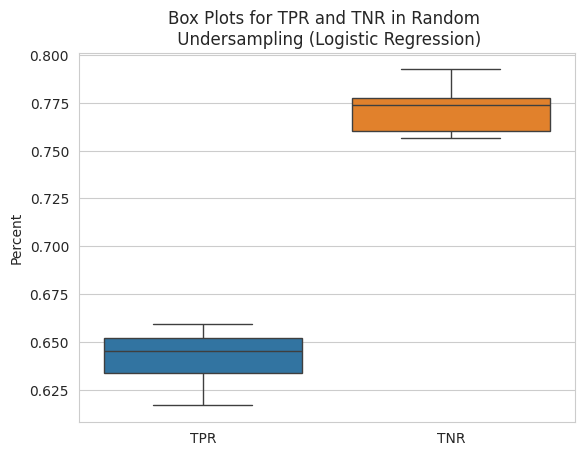

In [191]:
rus_boxplots = pd.DataFrame({'TPR': TPR, 'TNR': TNR})

sns.boxplot(data = rus_boxplots)
plt.title('Box Plots for TPR and TNR in Random \n Undersampling (Logistic Regression)')
plt.ylabel('Percent')
plt.show()

In [193]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from collections import Counter
import pandas as pd

# Number of trials
number_of_repeatations = 10

# Declare empty lists for true-positive and true-negative rates
TNR_smote = []
TPR_smote = []

# For loop for multiple trials
for trial in range(number_of_repeatations):
    # SMOTE oversampling
    sm = SMOTE(random_state=31 * trial)  # Randomized seed
    X_resamp, Y_resamp = sm.fit_resample(X, Y)  # Corrected method
    print(Counter(Y_resamp))  # Print results for each trial

    # Train/test split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(
        X_resamp, Y_resamp, test_size=0.2, stratify=Y_resamp
    )

    # Hyperparameter tuning with grid search
    C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    clf_grid = GridSearchCV(
        LogisticRegression(penalty='l2'), C_grid, cv=5, scoring='accuracy'
    )
    clf_grid.fit(Xtrain, Ytrain)
    print(clf_grid.best_params_, clf_grid.best_score_)

    # Train logistic regression with the best parameter
    clf_grid_best = LogisticRegression(C=clf_grid.best_params_['C'], penalty='l2')
    clf_grid_best.fit(Xtrain, Ytrain)

    # Evaluate on training data
    x_pred_train = clf_grid_best.predict(Xtrain)
    print("Training Accuracy:", accuracy_score(Ytrain, x_pred_train))

    # Evaluate on test data
    x_pred_test = clf_grid_best.predict(Xtest)
    print("Test Accuracy:", accuracy_score(Ytest, x_pred_test))

    # Confusion matrix
    actual = pd.Series(Ytest, name='Actual')
    predicted_sm = pd.Series(clf_grid_best.predict(Xtest), name='Predicted')
    ct_sm = pd.crosstab(actual, predicted_sm, margins=True)
    print(ct_sm)

    # Calculate true negative rate (TNR)
    tnr_smote = ct_sm.iloc[0, 0] / ct_sm.iloc[0, 2]
    TNR_smote.append(tnr_smote)

    # Calculate true positive rate (TPR)
    tpr_smote = ct_sm.iloc[1, 1] / ct_sm.iloc[1, 2]
    TPR_smote.append(tpr_smote)

    # Print metrics and trial count
    print('Logistic Regression accuracy for not readmitted: {}'.format('%0.3f' % tnr_smote))
    print('Logistic Regression accuracy for readmitted (Recall): {}'.format('%0.3f' % tpr_smote))
    print('Logistic Regression trial count: {}'.format(trial + 1))
    print()

Counter({1: 61919, 0: 61919})
{'C': 10} 0.7474815786817401
Training Accuracy: 0.746290501665489
Test Accuracy: 0.7447109173126615
Predicted      0      1    All
Actual                        
0           9243   3141  12384
1           3182   9202  12384
All        12425  12343  24768
Logistic Regression accuracy for not readmitted: 0.746
Logistic Regression accuracy for readmitted (Recall): 0.743
Logistic Regression trial count: 1

Counter({1: 61919, 0: 61919})
{'C': 100} 0.7479156152215605
Training Accuracy: 0.7487231250630867
Test Accuracy: 0.7436208010335917
Predicted      0      1    All
Actual                        
0           9287   3097  12384
1           3253   9131  12384
All        12540  12228  24768
Logistic Regression accuracy for not readmitted: 0.750
Logistic Regression accuracy for readmitted (Recall): 0.737
Logistic Regression trial count: 2

Counter({1: 61919, 0: 61919})
{'C': 100} 0.7463106894115272
Training Accuracy: 0.7446452003633794
Test Accuracy: 0.75024224806

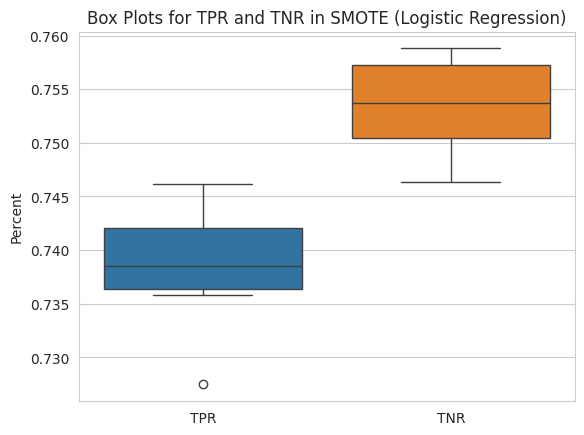

In [194]:
# Box plot for TPR and TNR

plots_for_oversample = pd.DataFrame({'TPR': TPR_smote, 'TNR': TNR_smote})
sns.boxplot(data = plots_for_oversample)
plt.title('Box Plots for TPR and TNR in SMOTE (Logistic Regression)')
plt.ylabel('Percent')
plt.show()

### Moving to random Forest


In [197]:
from collections import Counter, OrderedDict
features = list(data_encoded)
features = [x for x in features if x not in ('Unnamed: 0', 'readmitted')]

X = data_encoded[features].values
y = data_encoded.readmitted.values
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = .2,random_state = 34, stratify = y)

# using our randomforest classifier and giving class weights so that we can even try to handle some imbalanced data
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import recall_score

clf_rf = RandomForestClassifier(random_state = 7, class_weight = {0: .1, 1: .9})
model_rf = clf_rf.fit(Xtrain, Ytrain)

print(model_rf.score(Xtest, Ytest))

0.9099992653001249


In [198]:
# Confusion Matrix
actual = pd.Series(Ytest, name = 'Actual')
predicted_rf = pd.Series(clf_rf.predict(Xtest), name = 'Predicted')
rf_ct = pd.crosstab(actual, predicted_rf, margins = True)
print(rf_ct)

Predicted      0   1    All
Actual                     
0          12377   7  12384
1           1218   9   1227
All        13595  16  13611


In [199]:
TN_rf = rf_ct.iloc[0,0] / rf_ct.iloc[0,2]
TP_rf = rf_ct.iloc[1,1] / rf_ct.iloc[1,2]
Prec_rf = rf_ct.iloc[1,1] / rf_ct.iloc[2,1]

print('Percent of Non-readmissions Detected: {}'.format('%0.3f' % TN_rf))
print('Percent of Readmissions Detected (Recall): {}'.format('%0.3f' % TP_rf))
print('Accuracy Among Predictions of Readmitted (Precision): {}'.format('%0.3f' % Prec_rf))

Percent of Non-readmissions Detected: 0.999
Percent of Readmissions Detected (Recall): 0.007
Accuracy Among Predictions of Readmitted (Precision): 0.562


In [201]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Assuming data_encoded, features, and readmitted are already defined
X = data_encoded[features].values
Y = data_encoded.readmitted.values

# Random undersampling
rus = RandomUnderSampler(random_state=34)
X_res, Y_res = rus.fit_resample(X, Y)  # Corrected method
print(Counter(Y_res))  # Print the distribution of the undersampled dataset

Counter({0: 6136, 1: 6136})


In [202]:
# TTS
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_res, Y_res, test_size = .2, random_state = 34, stratify = Y_res)

# random classifier on this undersampled data
rf_rus = RandomForestClassifier(random_state = 7)
rf_model_rus = rf_rus.fit(Xtrain, Ytrain)
print(rf_model_rus.score(Xtest, Ytest))

# Confusion MAtrix
actual = pd.Series(Ytest, name = 'Actual')
predicted_rf_rus = pd.Series(rf_rus.predict(Xtest), name = 'Predicted')
ct_rf_rus = pd.crosstab(actual, predicted_rf_rus, margins = True)
print(ct_rf_rus)



0.7535641547861507
Predicted     0     1   All
Actual                     
0           916   311  1227
1           294   934  1228
All        1210  1245  2455


In [203]:
TN_rf_rus = ct_rf_rus.iloc[0,0] / ct_rf_rus.iloc[0,2]
TP_rf_rus = ct_rf_rus.iloc[1,1] / ct_rf_rus.iloc[1,2]
Prec_rf_rus = ct_rf_rus.iloc[1,1] / ct_rf_rus.iloc[2,1]

print('Percent of Non-readmissions Detected: {}'.format('%0.3f' % TN_rf_rus))
print('Percent of Readmissions Detected (Recall): {}'.format('%0.3f' % TP_rf_rus))
print('Accuracy Among Predictions of Readmitted (Precision): {}'.format('%0.3f' % Prec_rf_rus))

Percent of Non-readmissions Detected: 0.747
Percent of Readmissions Detected (Recall): 0.761
Accuracy Among Predictions of Readmitted (Precision): 0.750


In [206]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assuming data_encoded, features, and readmitted are already defined
X = data_encoded[features].values
Y = data_encoded.readmitted.values

# Oversampling the minority class using SMOTE
sm = SMOTE(random_state=137)
X_resamp, Y_resamp = sm.fit_resample(X, Y)  # Corrected method
print(Counter(Y_resamp))  # Print the distribution of the oversampled dataset

Counter({1: 61919, 0: 61919})


In [207]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resamp, Y_resamp, test_size = .2,random_state = 34, stratify = Y_resamp)


In [208]:
# on oversammpled data
clf_rf_sm = RandomForestClassifier(random_state = 7)
model_rf_sm = clf_rf_sm.fit(Xtrain, Ytrain)
print(model_rf_sm.score(Xtest, Ytest))

0.9276485788113695


In [209]:
# F1 score
from sklearn.metrics import f1_score
f1_score(Ytest[0:13611], y_pred, average='macro')

0.33255874611735387

In [210]:
from sklearn.metrics import f1_score
f1_score(Ytest[0:13611], y_pred, average='micro')

0.49709793549335096

In [211]:
# Confusion MAtrix
actual = pd.Series(Ytest, name = 'Actual')
predicted_rf_sm = pd.Series(clf_rf_sm.predict(Xtest), name = 'Predicted')
ct_rf_sm = pd.crosstab(actual, predicted_rf_sm, margins = True)
print(ct_rf_sm)


Predicted      0      1    All
Actual                        
0          11634    750  12384
1           1042  11342  12384
All        12676  12092  24768


In [212]:
TN_rf_sm = ct_rf_sm.iloc[0,0] / ct_rf_sm.iloc[0,2]
TP_rf_sm = ct_rf_sm.iloc[1,1] / ct_rf_sm.iloc[1,2]
Prec_rf_sm = ct_rf_sm.iloc[1,1] / ct_rf_sm.iloc[2,1]

print('Percent of Non-readmissions Detected: {}'.format('%0.3f' % TN_rf_sm))
print('Percent of Readmissions Detected (Recall): {}'.format('%0.3f' % TP_rf_sm))
print('Accuracy Among Predictions of Readmitted (Precision): {}'.format('%0.3f' % Prec_rf_sm))

Percent of Non-readmissions Detected: 0.939
Percent of Readmissions Detected (Recall): 0.916
Accuracy Among Predictions of Readmitted (Precision): 0.938


In [213]:
# best number of of features

RANDOM_STATE = 123

# warm_start
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True, max_features="sqrt", random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2', oob_score=True, random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None, oob_score=True, random_state=RANDOM_STATE))
]

In [214]:
# Map classifier name to a list of (<n_estimators>, <error rate>) pairs
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 40
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(Xtrain, Ytrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

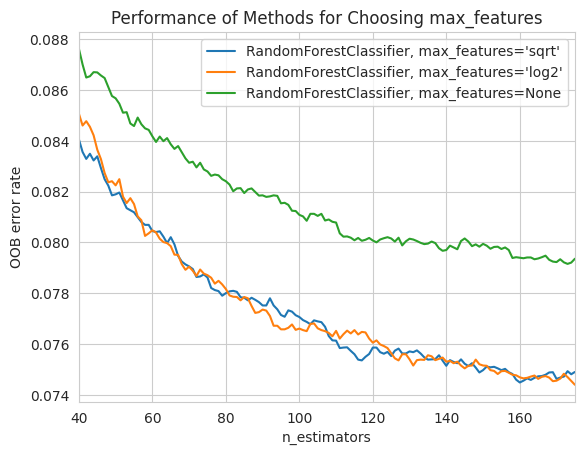

In [215]:
#  "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title('Performance of Methods for Choosing max_features')
plt.legend(loc="upper right")
plt.show()

In [219]:
import math
f = len(list(data_encoded[features]))
print(math.log(f, 2))

5.523561956057013


### Final MOdel

In [221]:
# Final Model
model_fin = RandomForestClassifier(random_state = 7, n_estimators = 85, max_features = 'log2', max_depth = 7)
clf_fin = model_fin.fit(Xtrain, Ytrain)
print(clf_fin.score(Xtest, Ytest))

0.7848433462532299


In [222]:
# Confusion Matrixz
actual_fin = pd.Series(Ytest, name = 'Actual')
predicted_fin = pd.Series(clf_fin.predict(Xtest), name = 'Predicted')
ct_fin = pd.crosstab(actual_fin, predicted_fin, margins = True)
print(ct_fin)


Predicted      0      1    All
Actual                        
0          10192   2192  12384
1           3137   9247  12384
All        13329  11439  24768


In [223]:
TN_fin = ct_fin.iloc[0,0] / ct_fin.iloc[0,2]
TP_fin = ct_fin.iloc[1,1] / ct_fin.iloc[1,2]
Prec_fin = ct_fin.iloc[1,1] / ct_fin.iloc[2,1]

print('Percent of Non-readmissions Detected: {}'.format('%0.3f' % TN_fin))
print('Percent of Readmissions Detected (Recall): {}'.format('%0.3f' % TP_fin))
print('Accuracy Among Predictions of Readmitted (Precision): {}'.format('%0.3f' % Prec_fin))

Percent of Non-readmissions Detected: 0.823
Percent of Readmissions Detected (Recall): 0.747
Accuracy Among Predictions of Readmitted (Precision): 0.808


In [225]:
importances = clf_fin.feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
imp = importance_df.sort_values('importance', ascending = False)
imp.head(10)

,feature,importance
40,num_visits,0.287923
38,change,0.109992
1,gender,0.105460
15,metformin,0.086732
32,insulin,0.056318
21,glipizide,0.038362
24,pioglitazone,0.033928
22,glyburide,0.033283
41,first_diag,0.030519
4,discharge_disposition_id,0.029676


In [226]:
print(imp[(imp.importance == 0)])


                     feature  importance
23               tolbutamide         0.0
37    metformin_pioglitazone         0.0
30                   examide         0.0
31               citoglipton         0.0
36   metformin_rosiglitazone         0.0
35  glimepiride_pioglitazone         0.0
44                     HbA1c         0.0


### Checking Validatrion

In [227]:
features = list(data_encoded)
features = [e for e in features if e not in ('Unnamed: 0', 'readmitted')]

In [228]:
X = data_encoded[features].values
Y = data_encoded.readmitted.values

In [230]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import pandas as pd

number_of_repeatations = 10  # number of trials

# Declare empty lists for true-positive and true-negative rates
TNR = []
TPR = []

# for loop for multiple trials
for trial in range(number_of_repeatations):
    # Random undersampling using fit_resample
    rus = RandomUnderSampler(random_state=11 * trial)  # randomized seed
    X_res, Y_res = rus.fit_resample(X, Y)  # Use fit_resample
    print(Counter(Y_res))

    # train, test, split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(
        X_res, Y_res, test_size=0.2, random_state=3 * trial, stratify=Y_res
    )

    # Random Forest model
    rf_rus = RandomForestClassifier(
        random_state=7, n_estimators=65, max_features='log2', max_depth=7
    )
    rf_model_rus = rf_rus.fit(Xtrain, Ytrain)
    print(rf_model_rus.score(Xtest, Ytest))

    # confusion matrix
    actual = pd.Series(Ytest, name='Actual')
    predicted_rf_rus = pd.Series(rf_rus.predict(Xtest), name='Predicted')
    ct_rf_rus = pd.crosstab(actual, predicted_rf_rus, margins=True)
    print(ct_rf_rus)

    # true negative rate
    tnr = ct_rf_rus.iloc[0, 0] / ct_rf_rus.iloc[0, 2]
    TNR.append(tnr)

    # true positive rate
    tpr = ct_rf_rus.iloc[1, 1] / ct_rf_rus.iloc[1, 2]
    TPR.append(tpr)

    # output metrics
    print('Accuracy for not readmitted: {}'.format('%0.3f' % tnr))
    print('Accuracy for readmitted (Recall): {}'.format('%0.3f' % tpr))
    print('Random Forest trial count: {}'.format(trial + 1))
    print()

Counter({0: 6136, 1: 6136})
0.745010183299389
Predicted     0     1   All
Actual                     
0           926   302  1228
1           324   903  1227
All        1250  1205  2455
Accuracy for not readmitted: 0.754
Accuracy for readmitted (Recall): 0.736
Random Forest trial count: 1

Counter({0: 6136, 1: 6136})
0.7421588594704684
Predicted     0     1   All
Actual                     
0           931   297  1228
1           336   891  1227
All        1267  1188  2455
Accuracy for not readmitted: 0.758
Accuracy for readmitted (Recall): 0.726
Random Forest trial count: 2

Counter({0: 6136, 1: 6136})
0.7478615071283096
Predicted     0     1   All
Actual                     
0           931   297  1228
1           322   905  1227
All        1253  1202  2455
Accuracy for not readmitted: 0.758
Accuracy for readmitted (Recall): 0.738
Random Forest trial count: 3

Counter({0: 6136, 1: 6136})
0.7409368635437882
Predicted     0     1   All
Actual                     
0           925   303 

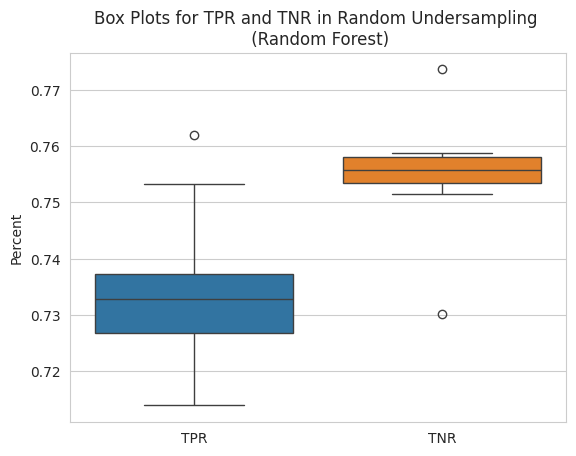

In [231]:
# plotting TPR and TNR

plots = pd.DataFrame({'TPR': TPR, 'TNR': TNR})
sns.boxplot(data = plots)
plt.title('Box Plots for TPR and TNR in Random Undersampling \n (Random Forest)')
plt.ylabel('Percent')
plt.show()

In [233]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import pandas as pd

number_of_repeatations = 10  # number of trials

# Declare empty lists for true-positive and true-negative rates
TNR_sm = []
TPR_sm = []

# for loop for multiple trials
for trial in range(number_of_repeatations):
    # SMOTE setup using fit_resample
    sm = SMOTE(random_state=13 * trial)
    X_resamp, Y_resamp = sm.fit_resample(X, Y)  # Use fit_resample
    print(Counter(Y_resamp))

    # train, test, split
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(
        X_resamp, Y_resamp, test_size=0.2, random_state=3 * trial, stratify=Y_resamp
    )

    # Random Forest model
    clf_rf_sm = RandomForestClassifier(
        random_state=7, n_estimators=65, max_features='log2', max_depth=7
    )
    model_rf_sm = clf_rf_sm.fit(Xtrain, Ytrain)
    print(model_rf_sm.score(Xtest, Ytest))

    # confusion matrix
    actual = pd.Series(Ytest, name='Actual')
    predicted_rf_sm = pd.Series(clf_rf_sm.predict(Xtest), name='Predicted')
    ct_rf_sm = pd.crosstab(actual, predicted_rf_sm, margins=True)
    print(ct_rf_sm)

    # true negative rate
    tnr_sm = ct_rf_sm.iloc[0, 0] / ct_rf_sm.iloc[0, 2]
    TNR_sm.append(tnr_sm)

    # true positive rate
    tpr_sm = ct_rf_sm.iloc[1, 1] / ct_rf_sm.iloc[1, 2]
    TPR_sm.append(tpr_sm)

    # output metrics
    print('Accuracy for not readmitted: {}'.format('%0.3f' % tnr_sm))
    print('Accuracy for readmitted (Recall): {}'.format('%0.3f' % tpr_sm))
    print('Random Forest trial count: {}'.format(trial + 1))
    print()

Counter({1: 61919, 0: 61919})
0.7868217054263565
Predicted      0      1    All
Actual                        
0          10153   2231  12384
1           3049   9335  12384
All        13202  11566  24768
Accuracy for not readmitted: 0.820
Accuracy for readmitted (Recall): 0.754
Random Forest trial count: 1

Counter({1: 61919, 0: 61919})
0.7916666666666666
Predicted      0      1    All
Actual                        
0          10209   2175  12384
1           2985   9399  12384
All        13194  11574  24768
Accuracy for not readmitted: 0.824
Accuracy for readmitted (Recall): 0.759
Random Forest trial count: 2

Counter({1: 61919, 0: 61919})
0.7918685400516796
Predicted      0      1    All
Actual                        
0          10265   2119  12384
1           3036   9348  12384
All        13301  11467  24768
Accuracy for not readmitted: 0.829
Accuracy for readmitted (Recall): 0.755
Random Forest trial count: 3

Counter({1: 61919, 0: 61919})
0.7799983850129198
Predicted      0      1 

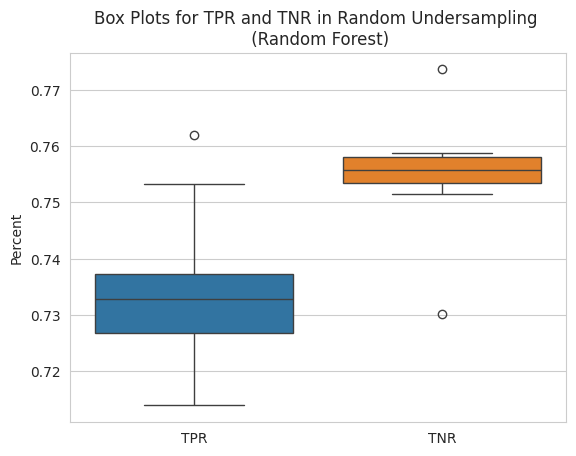

In [236]:
plots = pd.DataFrame({'TPR': TPR, 'TNR': TNR})
sns.boxplot(data = plots)
plt.title('Box Plots for TPR and TNR in Random Undersampling \n (Random Forest)')
plt.ylabel('Percent')
plt.show()

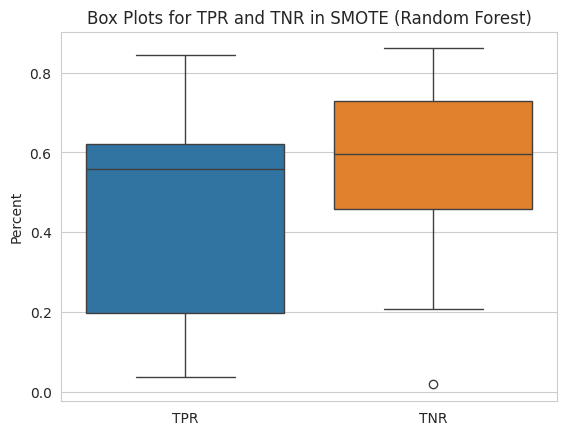

In [237]:
# BoxPLot

plots_sm = pd.DataFrame({'TPR': TPR_sm, 'TNR': TNR_sm})

sns.boxplot(data = plots_sm)
plt.title('Box Plots for TPR and TNR in SMOTE (Random Forest)')
plt.ylabel('Percent')
plt.show()

In [238]:
Result_Table = pd.DataFrame({'MODEL':['Logistic regression'],' Accuracy for train data for being readmitted':[0.515],' Accuracy for train data for non-readmitted':[0.838],'Accuracy for test data for being readmitted':[0.420],'Accuracy for test data for non-readmitted':[0.857]})



In [239]:
Result_Table


,MODEL,Accuracy for train data for being readmitted,Accuracy for train data for non-readmitted,Accuracy for test data for being readmitted,Accuracy for test data for non-readmitted
0,Logistic regression,0.515,0.838,0.42,0.857


In [240]:
Result_Table = pd.DataFrame({'MODEL':['Custom-Ensemble-Model','Stacking-Classifier','Logistic regression','Random Forest'],'Macro-F1-Score':[0.19,0.49,0.33,0.33],'Weighted-F1-Score':[0.71,0.91,0.50,0.5],'Micro-F1-Score':[0.6,0.87,0.34,0.33],'Accuracy':[0.6,0.91,0.92,0.94]})


In [241]:
Result_Table


,MODEL,Macro-F1-Score,Weighted-F1-Score,Micro-F1-Score,Accuracy
0,Custom-Ensemble-Model,0.19,0.71,0.60,0.60
1,Stacking-Classifier,0.49,0.91,0.87,0.91
2,Logistic regression,0.33,0.50,0.34,0.92
3,Random Forest,0.33,0.50,0.33,0.94


from matplotlib import pyplot as plt
Result_Table['Macro-F1-Score'].plot(kind='hist', bins=20, title='Macro-F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
Result_Table['Weighted-F1-Score'].plot(kind='hist', bins=20, title='Weighted-F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
Result_Table['Micro-F1-Score'].plot(kind='hist', bins=20, title='Micro-F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
Result_Table['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
Result_Table.plot(kind='scatter', x='Macro-F1-Score', y='Weighted-F1-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
Result_Table.plot(kind='scatter', x='Weighted-F1-Score', y='Micro-F1-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
Result_Table.plot(kind='scatter', x='Micro-F1-Score', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Accuracy']
  ys = series['Macro-F1-Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = Result_Table.sort_values('Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('Macro-F1-Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Accuracy']
  ys = series['Weighted-F1-Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = Result_Table.sort_values('Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('Weighted-F1-Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Accuracy']
  ys = series['Micro-F1-Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = Result_Table.sort_values('Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('Micro-F1-Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = Result_Table.sort_values('Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
Result_Table['Macro-F1-Score'].plot(kind='line', figsize=(8, 4), title='Macro-F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
Result_Table['Weighted-F1-Score'].plot(kind='line', figsize=(8, 4), title='Weighted-F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
Result_Table['Micro-F1-Score'].plot(kind='line', figsize=(8, 4), title='Micro-F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
Result_Table['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

In [252]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=Result_Table)

https://docs.google.com/spreadsheets/d/1rtvPWlUnJ2I71u18AazJ0QkbjFETGf7QXtsz0baQLI0#gid=0


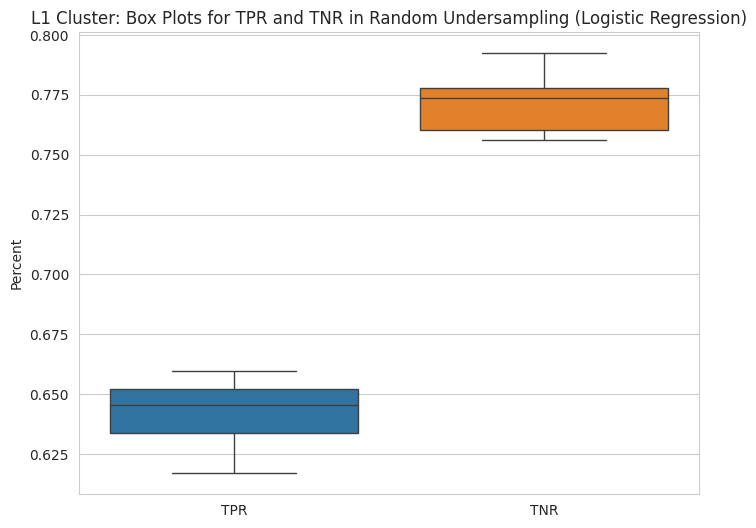

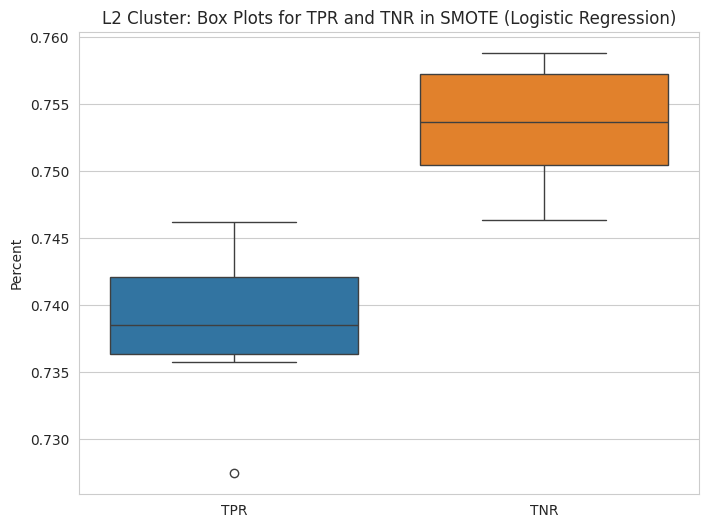

In [254]:
# show l1 and l2 clusters

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'rus_boxplots' and 'plots_for_oversample' DataFrames are already defined from your code.

# L1 Cluster (Random Undersampling - Logistic Regression)
plt.figure(figsize=(8, 6))
sns.boxplot(data=rus_boxplots)
plt.title('L1 Cluster: Box Plots for TPR and TNR in Random Undersampling (Logistic Regression)')
plt.ylabel('Percent')
plt.show()

# L2 Cluster (SMOTE - Logistic Regression)
plt.figure(figsize=(8, 6))
sns.boxplot(data=plots_for_oversample)
plt.title('L2 Cluster: Box Plots for TPR and TNR in SMOTE (Logistic Regression)')
plt.ylabel('Percent')
plt.show()


In [250]:
# Using dataframe Result_Table: suggest a plot

import altair as alt

# Convert the 'MODEL' column to a categorical type for proper ordering in the plot
Result_Table['MODEL'] = Result_Table['MODEL'].astype('category')

# Create a bar chart for each metric
chart1 = alt.Chart(Result_Table).mark_bar().encode(
    x='MODEL',
    y='Macro-F1-Score',
    color='MODEL',
    tooltip=['MODEL', 'Macro-F1-Score']
).properties(title='Macro-F1-Score by Model')


chart2 = alt.Chart(Result_Table).mark_bar().encode(
    x='MODEL',
    y='Weighted-F1-Score',
    color='MODEL',
    tooltip=['MODEL', 'Weighted-F1-Score']
).properties(title='Weighted-F1-Score by Model')


chart3 = alt.Chart(Result_Table).mark_bar().encode(
    x='MODEL',
    y='Micro-F1-Score',
    color='MODEL',
    tooltip=['MODEL', 'Micro-F1-Score']
).properties(title='Micro-F1-Score by Model')

chart4 = alt.Chart(Result_Table).mark_bar().encode(
    x='MODEL',
    y='Accuracy',
    color='MODEL',
    tooltip=['MODEL', 'Accuracy']
).properties(title='Accuracy by Model')


# Combine all charts into a single display
(chart1 & chart2) | (chart3 & chart4)


alt.HConcatChart(...)

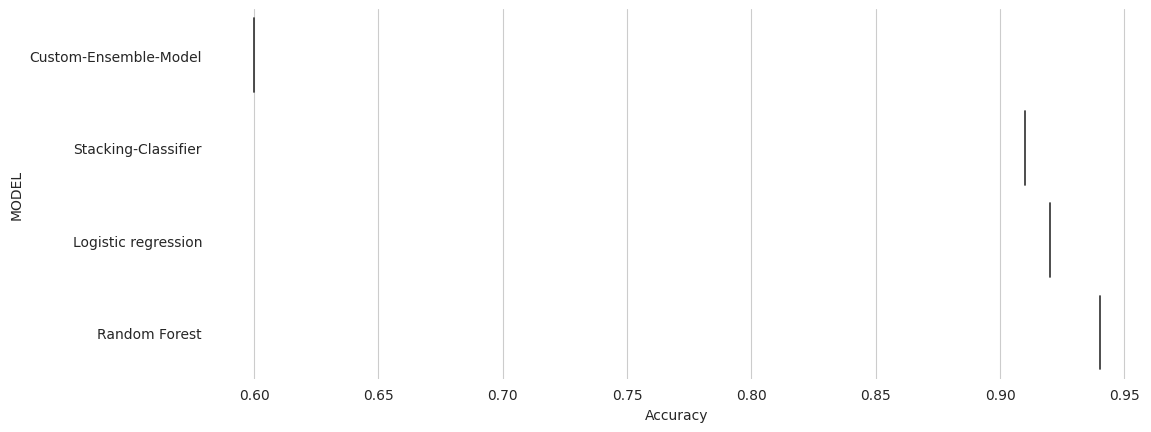

In [248]:
# @title MODEL vs Accuracy

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(Result_Table['MODEL'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(Result_Table, x='Accuracy', y='MODEL', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

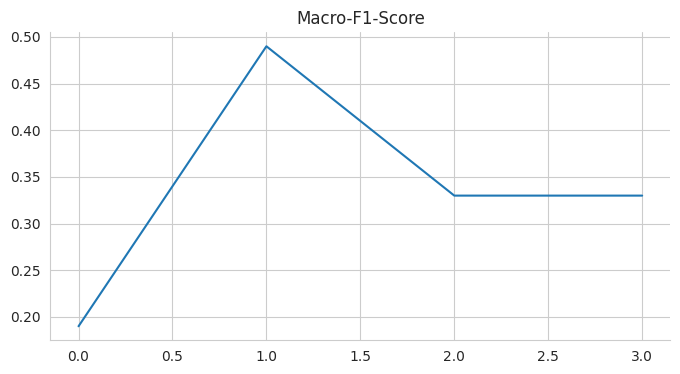

In [247]:
# @title Macro-F1-Score

from matplotlib import pyplot as plt
Result_Table['Macro-F1-Score'].plot(kind='line', figsize=(8, 4), title='Macro-F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

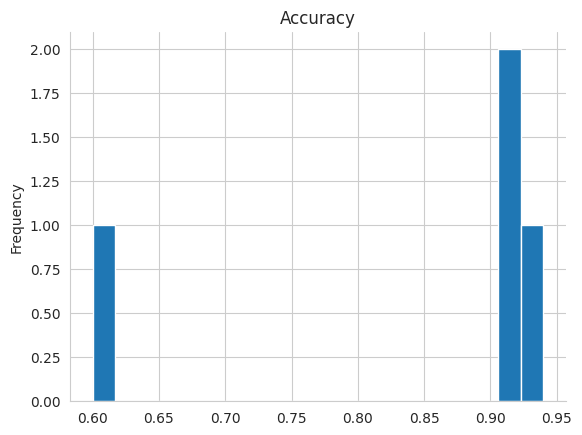

In [245]:
# @title Accuracy

from matplotlib import pyplot as plt
Result_Table['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

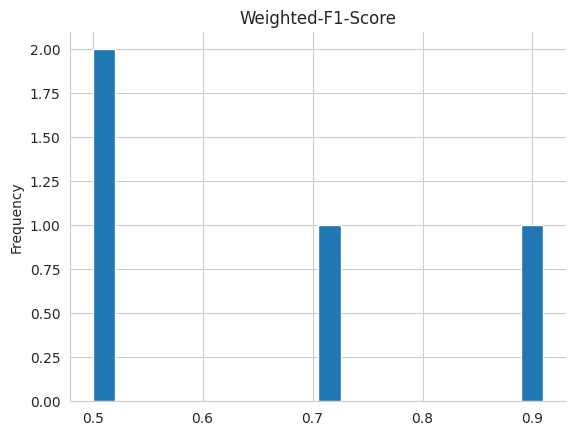

In [244]:
# @title Weighted-F1-Score

from matplotlib import pyplot as plt
Result_Table['Weighted-F1-Score'].plot(kind='hist', bins=20, title='Weighted-F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

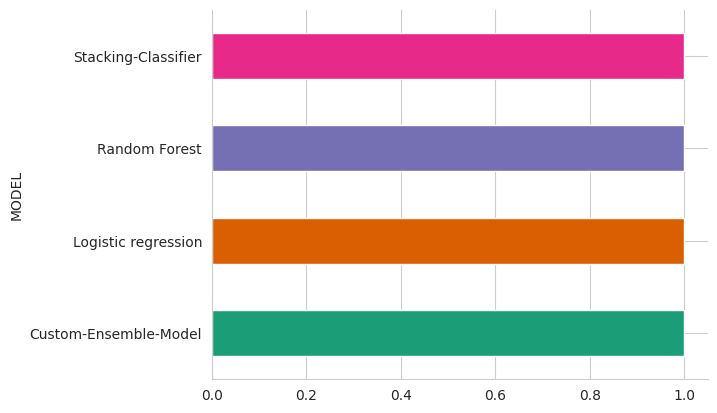

In [243]:
# @title MODEL

from matplotlib import pyplot as plt
import seaborn as sns
Result_Table.groupby('MODEL').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

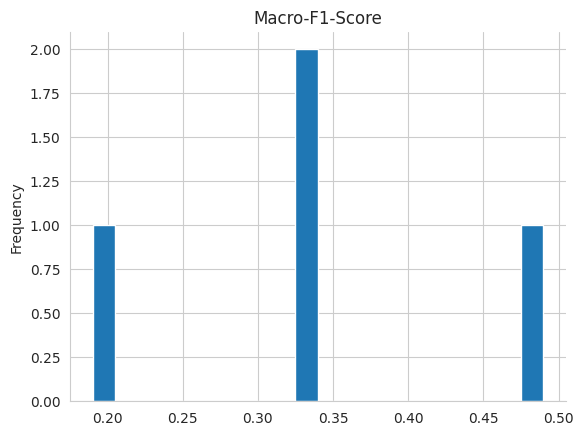

In [242]:
# @title Macro-F1-Score

from matplotlib import pyplot as plt
Result_Table['Macro-F1-Score'].plot(kind='hist', bins=20, title='Macro-F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)